# clone detection

In [157]:
import gzip, time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns
from Bio.Seq import Seq
from collections import Counter
import os
import cassiopeia as cas
from cassiopeia.mixins import logger
from typing import Dict, List, Tuple
from cassiopeia.preprocess import (
    alignment_utilities,
    constants,
    map_utils,
    doublet_utils,
    lineage_utils,
    UMI_utils,
    utilities,
)

import gzip, time
import pickle as pic

In [158]:
umi_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/cassiopeia_result/staticBC/umi_table_filtered.csv',
                               sep=',',index_col=0,header=0,keep_default_na=False)

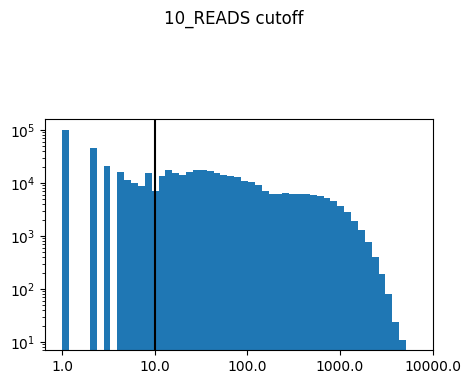

In [159]:
plt.figure(figsize=(5,3))
plt.hist(np.log(umi_table['readCount'])/np.log(10), bins=50)
plt.axvline(np.log(10)/np.log(10),c='k')
plt.xticks(range(5),np.logspace(0,4,5))
plt.text(np.log(10)/np.log(10)*1.1,10**7,'10_READS cutoff', fontsize=12)
plt.yscale('log')

In [160]:
umi_table.shape

(528601, 8)

In [161]:
umi_table = umi_table[umi_table['readCount'] >= 10]

In [162]:
umi_table.shape

(299318, 8)

In [163]:
umi_table.head()

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq
0,AAAAAAAAAACCGTTCCAGAAACTC_CGGATGAACC_48,CGGATGAACC,AAAAAAAAAACCGTTCCAGAAACTC,0,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,48,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...
1,AAAAAAAAAGATTGACGAGTCTAAG_TGCTTGTCCG_49,TGCTTGTCCG,AAAAAAAAAGATTGACGAGTCTAAG,0,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,49,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACGCGGAGCG...
4,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_40,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,40,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...
6,AAAAAAACACTGGCATCCGGCTTCG_ATCCGCCTGA_575,ATCCGCCTGA,AAAAAAACACTGGCATCCGGCTTCG,0+,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,575,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGTGTAGGCC...
8,AAAAAAACATTAGGCACTACGCCCA_CGTAGACGAC_12,CGTAGACGAC,AAAAAAACATTAGGCACTACGCCCA,0+,staticBC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,12,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACA...


In [164]:
def is_valid(bc):
    return (bc[0:8]=='CACTTTTT' and bc[22:27]=='AAAAG') or (bc[0:28]=='CACTTTTTTCTAGATGAGAAGCGAAAAG')

    
def is_valid_staticBC_prefix(r2_line): # need to 1 mismatch
    staticBC_prefix = 'ATCTGACAGTCACTGTGACG'
    return staticBC_prefix in r2_line

In [165]:
staticBC_prefix = 'ATCTGACAGTCACTGTGACG'
umi_table['umi_valid'] = 'F'
umi_table['intBC'] = 'None'
counter = 0
for i in range(0,len(umi_table.index)):
    counter += 1
    if counter % 100000 == 0: print(counter)
    
    seq = umi_table.iloc[i,7]
    if is_valid_staticBC_prefix(seq): 
        seq_sub = seq.split(staticBC_prefix)[1][:31]
        if is_valid(seq_sub):
            umi_table.iloc[i,8] = 'T'
            if seq_sub[0:28]=='CACTTTTTTCTAGATGAGAAGCGAAAAG':
                staticBC = 'TCTAGATGAGAAGCG'
            else:
                staticBC = seq_sub[8:22] 
            umi_table.iloc[i,4] = staticBC

100000
200000


In [166]:
umi_table = umi_table[umi_table['umi_valid']=='T']

In [167]:
umi_table

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq,umi_valid
0,AAAAAAAAAACCGTTCCAGAAACTC_CGGATGAACC_48,CGGATGAACC,AAAAAAAAAACCGTTCCAGAAACTC,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,48,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T
1,AAAAAAAAAGATTGACGAGTCTAAG_TGCTTGTCCG_49,TGCTTGTCCG,AAAAAAAAAGATTGACGAGTCTAAG,0,GGACGCGGAGCGGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,49,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACGCGGAGCG...,T
4,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_40,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,GGGGGGGCCGCAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,40,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...,T
6,AAAAAAACACTGGCATCCGGCTTCG_ATCCGCCTGA_575,ATCCGCCTGA,AAAAAAACACTGGCATCCGGCTTCG,0+,GGCGTGTAGGCCCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,575,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGTGTAGGCC...,T
8,AAAAAAACATTAGGCACTACGCCCA_CGTAGACGAC_12,CGTAGACGAC,AAAAAAACATTAGGCACTACGCCCA,0+,CCAAATCGGACATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,12,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACA...,T
...,...,...,...,...,...,...,...,...,...
528589,TTTTTTTTCACCAGCGCGACTATCA_CCGAGCTTTC_310,CCGAGCTTTC,TTTTTTTTCACCAGCGCGACTATCA,0+,GTGCAACGTGTTGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,310,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGTGCAACGTGTT...,T
528593,TTTTTTTTGCGGACGCTCGAATATG_CACGGCGAAT_132,CACGGCGAAT,TTTTTTTTGCGGACGCTCGAATATG,0+,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,132,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T
528595,TTTTTTTTTAGCACGCTACCTATCA_CACGCTACTG_326,CACGCTACTG,TTTTTTTTTAGCACGCTACCTATCA,0+,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,326,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T
528596,TTTTTTTTTAGCACGCTACCTATCA_CGGCGGTCGA_185,CGGCGGTCGA,TTTTTTTTTAGCACGCTACCTATCA,0+,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,185,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T


In [168]:
barcodeToPos_df = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/barcodeToPos.txt',sep='\t',header=None)
barcodeToPos_df.columns = ['CID','x','y']
barcodeToPos_df['x_y'] = barcodeToPos_df['x'].astype('str') + '_' + barcodeToPos_df['y'].astype('str')
barcodeToPos_dict = barcodeToPos_df.set_index('CID')['x_y'].to_dict()

In [169]:
umi_table['x_y'] = [ barcodeToPos_dict[CID] for CID in umi_table['cellBC'] ]

In [170]:
umi_table

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq,umi_valid,x_y
0,AAAAAAAAAACCGTTCCAGAAACTC_CGGATGAACC_48,CGGATGAACC,AAAAAAAAAACCGTTCCAGAAACTC,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,48,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,7795_3248
1,AAAAAAAAAGATTGACGAGTCTAAG_TGCTTGTCCG_49,TGCTTGTCCG,AAAAAAAAAGATTGACGAGTCTAAG,0,GGACGCGGAGCGGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,49,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACGCGGAGCG...,T,8317_8748
4,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_40,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,GGGGGGGCCGCAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,40,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...,T,3749_9988
6,AAAAAAACACTGGCATCCGGCTTCG_ATCCGCCTGA_575,ATCCGCCTGA,AAAAAAACACTGGCATCCGGCTTCG,0+,GGCGTGTAGGCCCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,575,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGTGTAGGCC...,T,8586_8454
8,AAAAAAACATTAGGCACTACGCCCA_CGTAGACGAC_12,CGTAGACGAC,AAAAAAACATTAGGCACTACGCCCA,0+,CCAAATCGGACATT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,12,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACA...,T,10312_7718
...,...,...,...,...,...,...,...,...,...,...
528589,TTTTTTTTCACCAGCGCGACTATCA_CCGAGCTTTC_310,CCGAGCTTTC,TTTTTTTTCACCAGCGCGACTATCA,0+,GTGCAACGTGTTGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,310,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGTGCAACGTGTT...,T,8279_10427
528593,TTTTTTTTGCGGACGCTCGAATATG_CACGGCGAAT_132,CACGGCGAAT,TTTTTTTTGCGGACGCTCGAATATG,0+,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,132,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,8109_10572
528595,TTTTTTTTTAGCACGCTACCTATCA_CACGCTACTG_326,CACGCTACTG,TTTTTTTTTAGCACGCTACCTATCA,0+,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,326,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T,7072_10203
528596,TTTTTTTTTAGCACGCTACCTATCA_CGGCGGTCGA_185,CGGCGGTCGA,TTTTTTTTTAGCACGCTACCTATCA,0+,GGCGCCAAACTCAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,185,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCGCCAAACTC...,T,7072_10203


In [171]:
gem = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/B03203C612.tissue.bin50.gem',
            sep='\t',header=0)
gem.columns = ['geneID','x','y','MIDCount','ExonCount','bin50_x','bin50_y','CellID']
gem['CellID'] = gem['CellID'].astype('str')
gem['x_y'] = gem['x'].astype('str') + '_' + gem['y'].astype('str')
gem = gem.drop_duplicates(subset='x_y',keep='first')

In [172]:
gem

,geneID,x,y,MIDCount,ExonCount,bin50_x,bin50_y,CellID,x_y
0,0610005C13Rik,1867,6064,1,0,1850,6050,1850_6050,1867_6064
1,0610005C13Rik,2088,8319,3,3,2050,8300,2050_8300,2088_8319
2,0610005C13Rik,2275,7616,1,0,2250,7600,2250_7600,2275_7616
3,0610005C13Rik,2379,6062,1,1,2350,6050,2350_6050,2379_6062
4,0610005C13Rik,2435,5611,1,1,2400,5600,2400_5600,2435_5611
...,...,...,...,...,...,...,...,...,...
144366676,mt-Nd6,11526,2711,1,1,11500,2700,11500_2700,11526_2711
144366677,mt-Nd6,11538,6655,1,1,11500,6650,11500_6650,11538_6655
144366679,mt-Nd6,11573,8197,2,2,11550,8150,11550_8150,11573_8197
144366680,mt-Nd6,11595,7452,1,1,11550,7450,11550_7450,11595_7452


In [173]:
umi_table = pd.merge(umi_table,gem,on='x_y',how='left')
umi_table = umi_table.dropna(axis=0,subset = ['CellID']) 

In [174]:
umi_table

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq,umi_valid,x_y,geneID,x,y,MIDCount,ExonCount,bin50_x,bin50_y,CellID
2,AAAAAAACACGCGACTAATGCCAGC_TCCTTGTATC_40,TCCTTGTATC,AAAAAAACACGCGACTAATGCCAGC,0+,GGGGGGGCCGCAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,40,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGGGGGGCCGCA...,T,3749_9988,Rcc1,3749.0,9988.0,3.0,3.0,3700.0,9950.0,3700_9950
5,AAAAAAACCCGAAGCGGTGGGACTT_CGCCTGGCGG_140,CGCCTGGCGG,AAAAAAACCCGAAGCGGTGGGACTT,0,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,140,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,3649_7689,Med11,3649.0,7689.0,1.0,1.0,3600.0,7650.0,3600_7650
6,AAAAAAACCGGAGCCGACCTGTATC_CACTATGTGC_145,CACTATGTGC,AAAAAAACCGGAGCCGACCTGTATC,0+,AGTGGGGACGTAGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,145,ACGATCATCTGACAGTCACTGTGACGCACTTTTTAGTGGGGACGTA...,T,6568_4067,Ccnb1,6568.0,4067.0,1.0,1.0,6550.0,4050.0,6550_4050
7,AAAAAAACGCCTAAAGGTACTCGTA_CCGTGTTCAT_25,CCGTGTTCAT,AAAAAAACGCCTAAAGGTACTCGTA,0,GGACACAGGCCCGG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,25,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGACACAGGCCC...,T,8812_3637,Atp5a1,8812.0,3637.0,1.0,1.0,8800.0,3600.0,8800_3600
8,AAAAAAACGGACCTGGCTTGGCCTG_CAGCGCCCCA_40,CAGCGCCCCA,AAAAAAACGGACCTGGCTTGGCCTG,0,GCCCCTGCCTACAA,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,40,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGCCCCTGCCTAC...,T,4615_4816,Gm42418,4615.0,4816.0,3.0,3.0,4600.0,4800.0,4600_4800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245620,TTTTTTTGTACAGACAGCGCCTTAT_CGCCACGTTC_19,CGCCACGTTC,TTTTTTTGTACAGACAGCGCCTTAT,0,CCGCCTTGTGAAAG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,19,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCGCCTTGTGAA...,T,4775_11122,Atox1,4775.0,11122.0,1.0,1.0,4750.0,11100.0,4750_11100
245621,TTTTTTTTACACCCGCACGGAGATC_ATATGCGTAC_22,ATATGCGTAC,TTTTTTTTACACCCGCACGGAGATC,0+,TCTAGATGAGAAGCG,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,22,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCTAGATGAGAA...,T,7937_3787,Dagla,7937.0,3787.0,2.0,2.0,7900.0,3750.0,7900_3750
245622,TTTTTTTTACTGCGACACTTATACC_CATTCGGGCG_11,CATTCGGGCG,TTTTTTTTACTGCGACACTTATACC,0,TCAGTGCGTGCCCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,11,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCAGTGCGTGCC...,T,6163_6197,Fbxl19,6163.0,6197.0,1.0,1.0,6150.0,6150.0,6150_6150
245623,TTTTTTTTAGTCTAGCGAGAGCTGA_GAGAGCCTAA_20,GAGAGCCTAA,TTTTTTTTAGTCTAGCGAGAGCTGA,0,CCAGGCCGAGACCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,20,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAGGCCGAGAC...,T,3608_10109,Asna1,3608.0,10109.0,1.0,1.0,3600.0,10100.0,3600_10100


In [175]:
umi_table['num'] = 1
umi_count = umi_table.groupby(by=['CellID','intBC'])['num'].sum().reset_index()
umi_count['num'].value_counts()

num
1     150202
2      13917
3       3045
4       1065
5        460
6        201
7        119
8         78
9         45
10        27
11        17
12        16
13        10
15         3
14         2
17         1
16         1
28         1
19         1
Name: count, dtype: int64

In [176]:
umi_table['num'] = 1
umi_count = umi_table.groupby(by=['CellID','intBC'])['num'].sum().reset_index()
umi_count = umi_count[umi_count['num'] >= 2]
umi_count

,CellID,intBC,num
8,10000_10050,CCGCCTTGTGAAAG,3
11,10000_10100,AGTGGGGACGTAGG,2
23,10000_10200,GACCAGCACGCGCA,2
24,10000_10200,GACTCCTGGCCGCT,2
28,10000_10250,GCCCCTGCCTACAA,2
...,...,...,...
169136,9950_9200,TCTAGATGAGAAGCG,2
169159,9950_9450,CCGCCTTGTGAAAG,2
169175,9950_9650,CCGCCTTGTGAAAG,3
169194,9950_9850,AGCTTGAATTTCGG,2


In [177]:
len(set(umi_count['CellID']))

14105

In [178]:
staticBC_whitelist = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/metadata/staticBC_whitelist.txt',header=None)
umi_count = umi_count[umi_count['intBC'].isin(staticBC_whitelist[0].to_list())]

In [179]:
umi_count

,CellID,intBC,num
8,10000_10050,CCGCCTTGTGAAAG,3
11,10000_10100,AGTGGGGACGTAGG,2
23,10000_10200,GACCAGCACGCGCA,2
24,10000_10200,GACTCCTGGCCGCT,2
28,10000_10250,GCCCCTGCCTACAA,2
...,...,...,...
169136,9950_9200,TCTAGATGAGAAGCG,2
169159,9950_9450,CCGCCTTGTGAAAG,2
169175,9950_9650,CCGCCTTGTGAAAG,3
169194,9950_9850,AGCTTGAATTTCGG,2


In [180]:
len(set(umi_count['CellID']))

14095

In [ ]:
umi_count.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/bin50_staticBC_new.csv',index=False)

/home/liangzhen/anaconda3/envs/cassiopeia2/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/liangzhen/anaconda3/envs/cassiopeia2/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


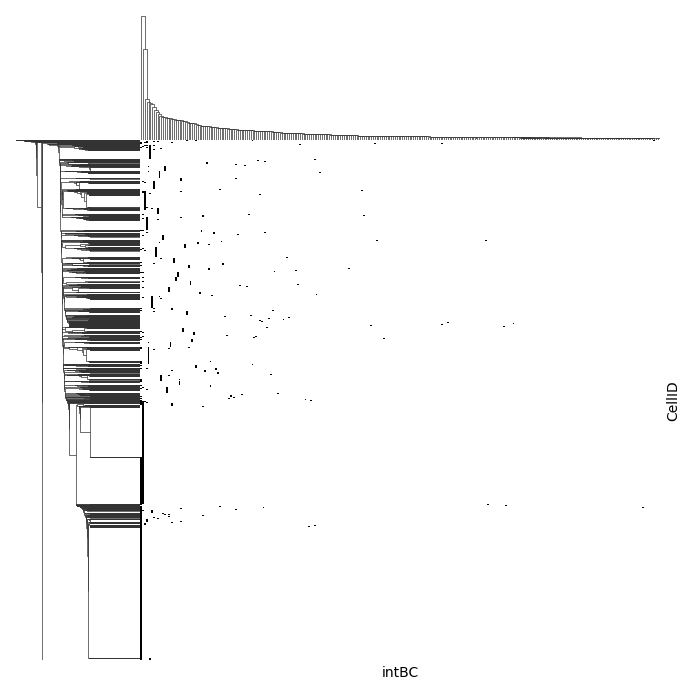

In [181]:
cellBC_staticBC_df = umi_count.pivot(index='CellID',columns='intBC',values='num')

cellBC_staticBC_df = cellBC_staticBC_df.fillna(0)

cellBC_staticBC_df[cellBC_staticBC_df > 0] = 1

import seaborn as sns
ax = sns.clustermap(cellBC_staticBC_df, yticklabels=False,xticklabels=False,cmap='binary',figsize=(7, 7),cbar=False)
ax.cax.set_visible(False)

In [182]:
cellBC_staticBC_df.shape

(14095, 285)

Text(0, 0.5, 'Number of cells')

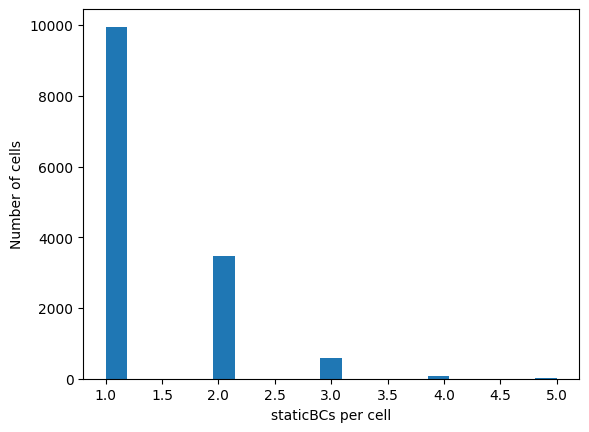

In [183]:
plt.hist(cellBC_staticBC_df.apply(sum,axis=1),bins=21)
plt.xlabel('staticBCs per cell')
plt.ylabel('Number of cells')

## alignment

In [184]:
import pickle as pic
import pandas as pd

In [185]:
with open('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/master_intBCs_filtered.pickle.BLEELE.new','rb')as f:
    master_intBCs_filtered = pic.load(f)

lineageGrp_intBCs = pd.DataFrame([master_intBCs_filtered]).T
lineageGrp_intBCs.columns = ['intBCs']
lineageGrp_intBCs

,intBCs
C1,"[CGGAACCTGAAAAC, GTTTTATCCGCCTG, CCAAATCGGACGT..."
C2,"[CCGTACGCGGCACG, ACACGACAAGAACG, GGCGCGCGTCATA..."
C3,"[AGGGGTGCAAAGCC, GGCCCGGTGCAGAG, GCATAGCCACCTG..."
C4,"[CGGCAAACGGGGGG, TGCTGTGAGCGCGC, AGTGGGGACGTAG..."
C5,"[CAGACCCCAGTCCG, GCCCCTGCCTACAA, GCGAGGGATCCAA..."
...,...
C172,"[GAGAAAGGCTCCGA, TGCGCAAGATAACC, TAATGCCACTTCCG]"
C171,"[ATCACGGCAAAATG, AAGGCGATCCCCGC, CGCCCTTGAGTGG..."
C173,"[TCGGGAGCACCAGG, CGGCCAAGGGAGGC]"
C174,"[TTGAGCCCTCCCTT, GGTGGAGCGAGCCG]"


In [186]:
cell_intBC = umi_count
cell_intBC

,CellID,intBC,num
8,10000_10050,CCGCCTTGTGAAAG,3
11,10000_10100,AGTGGGGACGTAGG,2
23,10000_10200,GACCAGCACGCGCA,2
24,10000_10200,GACTCCTGGCCGCT,2
28,10000_10250,GCCCCTGCCTACAA,2
...,...,...,...
169136,9950_9200,TCTAGATGAGAAGCG,2
169159,9950_9450,CCGCCTTGTGAAAG,2
169175,9950_9650,CCGCCTTGTGAAAG,3
169194,9950_9850,AGCTTGAATTTCGG,2


In [187]:
len(set(cell_intBC['CellID']))

14095

In [188]:
cell_lineageGrp = []

for CellID,intBC in zip(cell_intBC.CellID,cell_intBC.intBC):
    for intBCs,lineageGrp in zip(lineageGrp_intBCs.intBCs,lineageGrp_intBCs.index):
        if intBC in intBCs:
            cell_lineageGrp.append([CellID,intBC,lineageGrp])
            continue

cell_lineageGrp_df = pd.DataFrame(cell_lineageGrp)
cell_lineageGrp_df.columns = ['CellID','intBC','lineageGrp']
cell_lineageGrp_df_weight = pd.merge(cell_intBC,cell_lineageGrp_df,on=['CellID','intBC'],how='inner')
#cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.drop_duplicates(subset=['CellID','num'],keep=False)
cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.groupby(['CellID','lineageGrp'])['num'].sum().reset_index()
cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.sort_values(['num'],ascending=False)
cell_lineageGrp_df_weight = cell_lineageGrp_df_weight.drop_duplicates(subset=['CellID'],keep='first')
cell_lineageGrp_df_weight.index = cell_lineageGrp_df_weight.CellID.astype('str')

In [189]:
len(set(cell_lineageGrp_df_weight['CellID']))

13626

In [190]:
cell_lineageGrp_df_weight['x'] = [ int(cell.split('_')[0]) for cell in cell_lineageGrp_df_weight['CellID']]
cell_lineageGrp_df_weight['y'] = [ int(cell.split('_')[1]) for cell in cell_lineageGrp_df_weight['CellID']]

In [282]:
cell_lineageGrp_df_weight.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv',index=False)

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

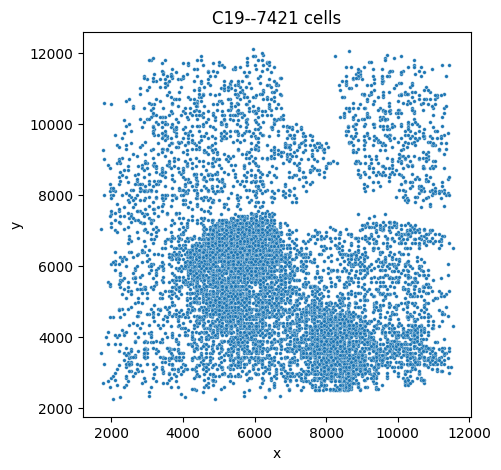

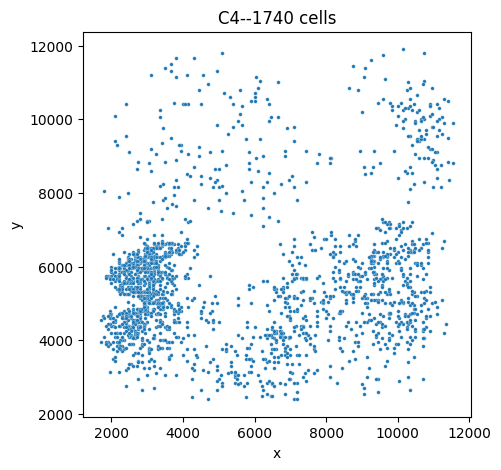

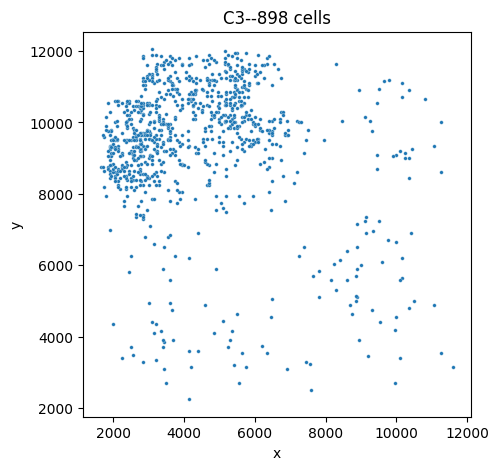

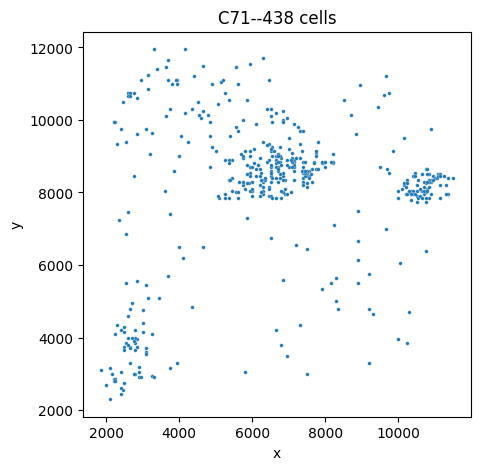

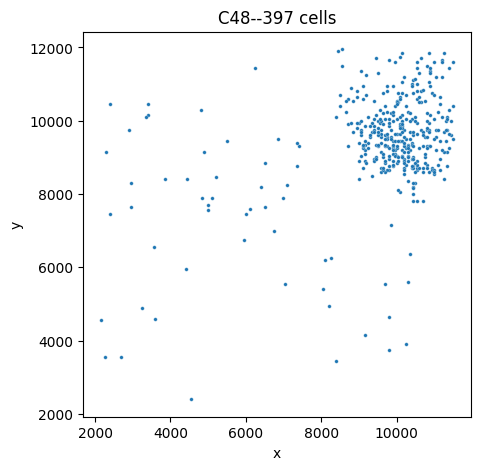

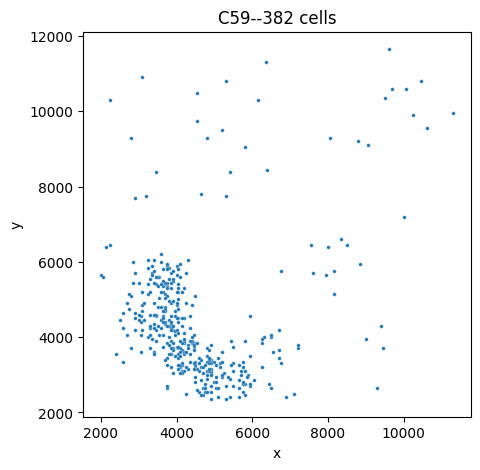

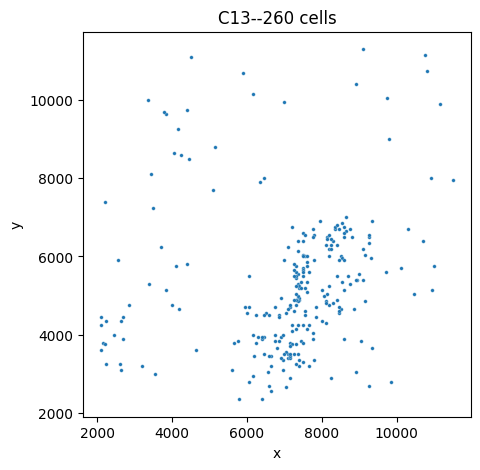

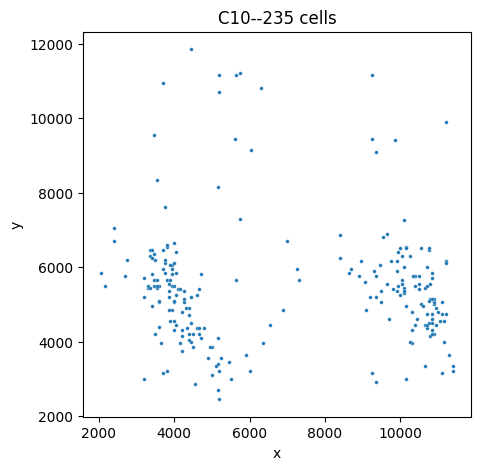

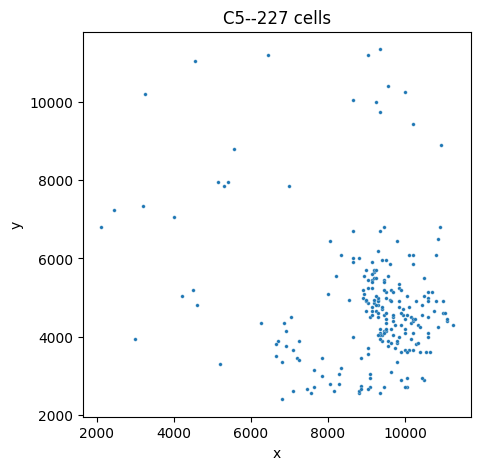

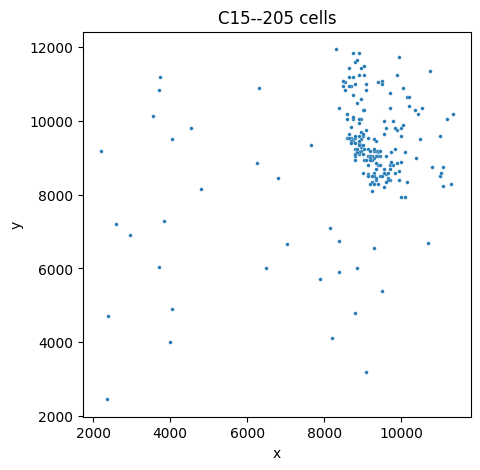

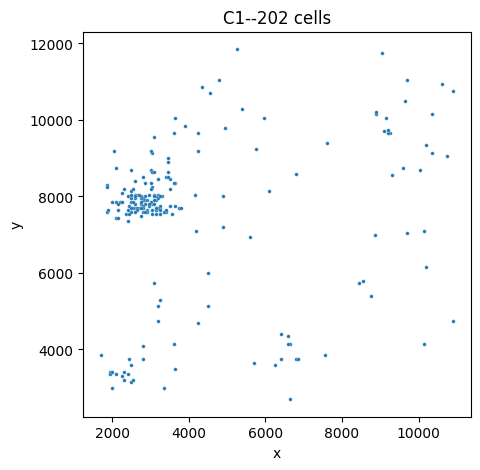

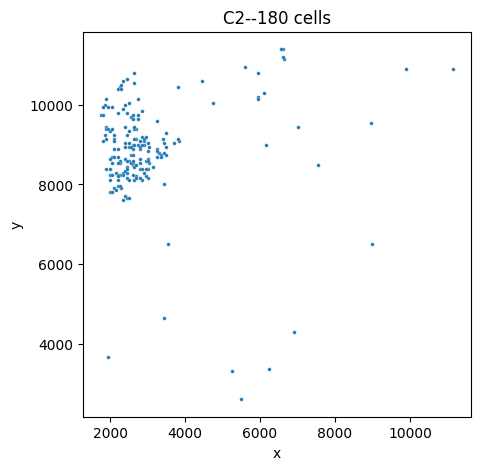

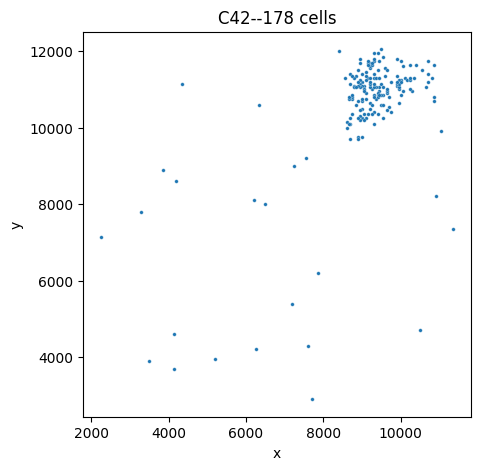

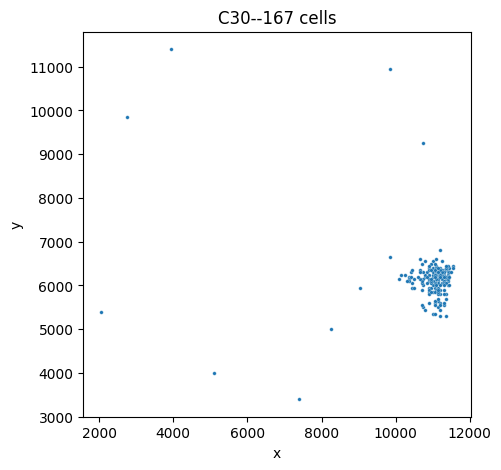

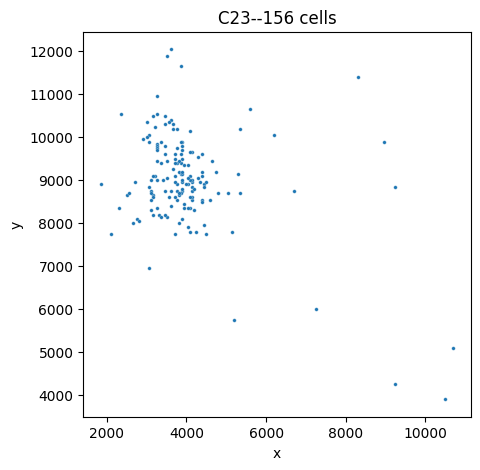

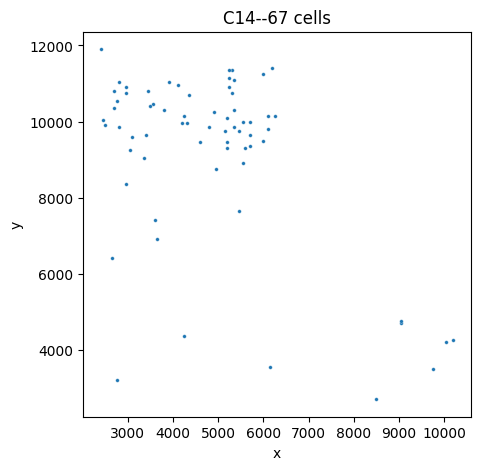

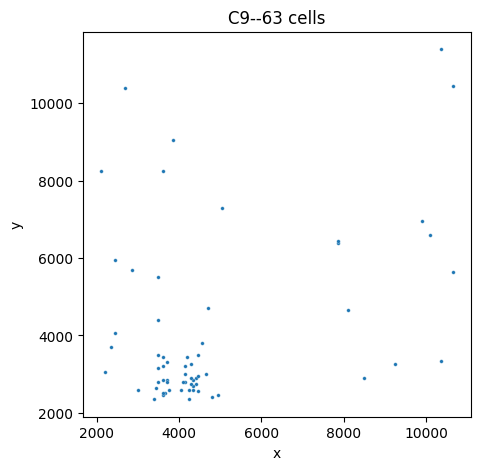

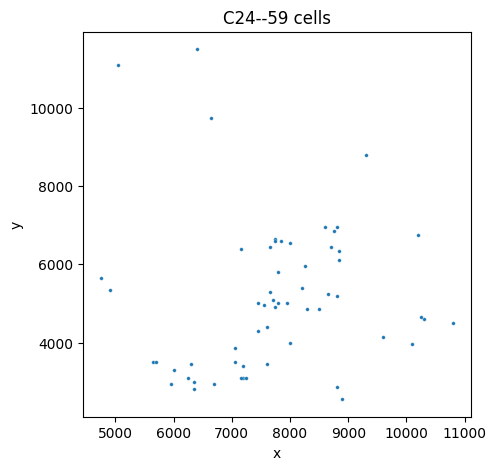

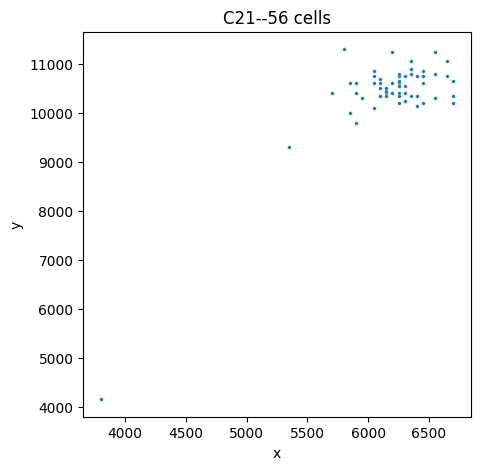

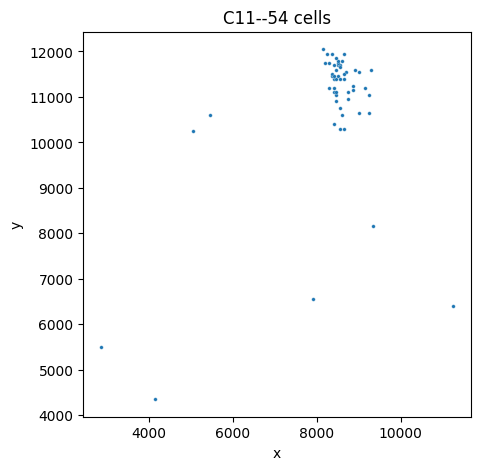

In [192]:
for clone in cell_lineageGrp_df_weight['lineageGrp'].value_counts().index[0:20]:
    spatial_lineageGrp_sub = cell_lineageGrp_df_weight[cell_lineageGrp_df_weight['lineageGrp']==clone]
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=spatial_lineageGrp_sub,x='x',y='y',s=7).set(title=str(clone)+'--'+str(spatial_lineageGrp_sub.shape[0])+' cells')
    plt.show()

## clone barcode heatmap

<Figure size 1500x1500 with 0 Axes>

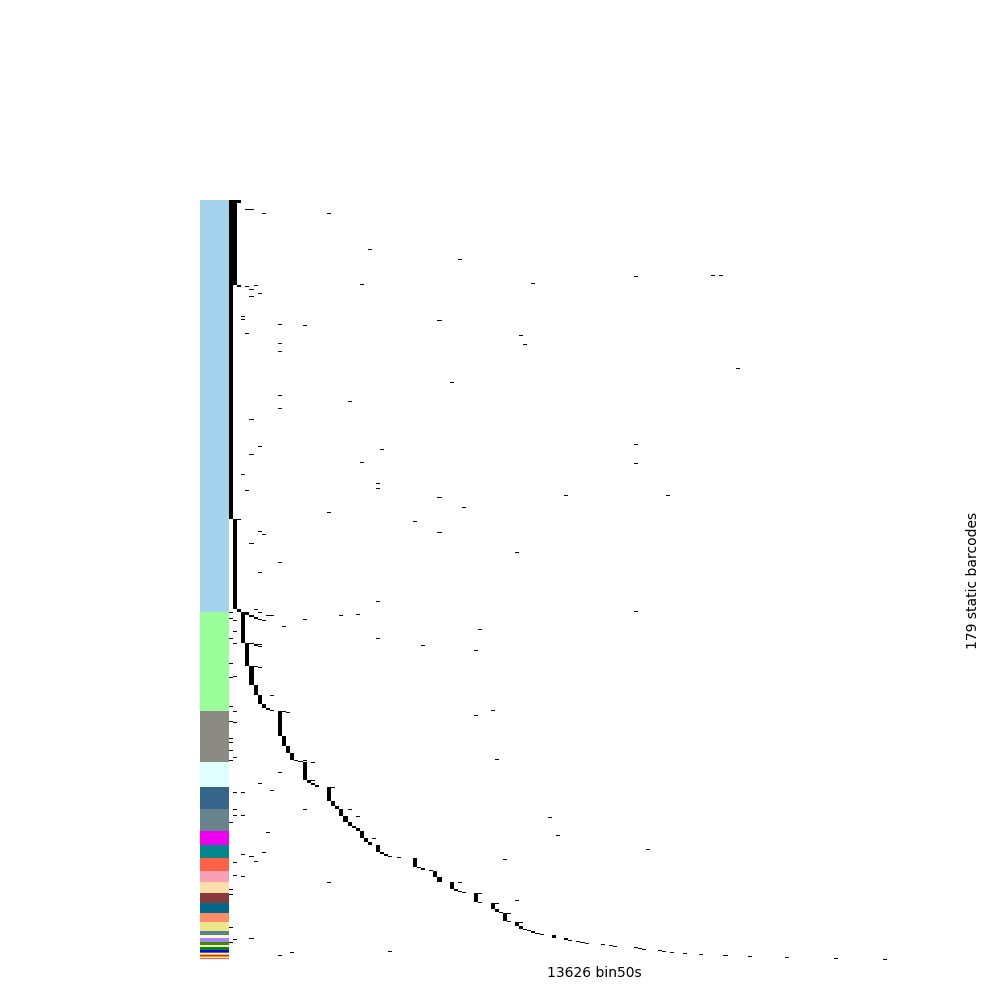

In [357]:
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv',header=0)
cell_lineage.index = cell_lineage.CellID
cell_lineage.index.name = 'test'

cell_intBC = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/bin50_staticBC_new.csv')

cell_intBC = cell_intBC[cell_intBC['CellID'].isin(cell_lineage['CellID'])]
cell_intBC['lineageGrp'] = cell_lineage.loc[cell_intBC['CellID'],'lineageGrp'].to_list()

with open('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/master_intBCs_filtered.pickle.BLEELE.new','rb')as f:
    master_intBCs_filtered = pic.load(f)
lineageGrp_intBCs = pd.DataFrame([master_intBCs_filtered]).T
lineageGrp_intBCs.columns = ['intBCs']
lineageGrp_intBCs = lineageGrp_intBCs[lineageGrp_intBCs.index.isin(set(cell_intBC['lineageGrp']))]
sc_lineageGrp_intBCs = sum(lineageGrp_intBCs['intBCs'], [])


cell_intBC = cell_intBC[cell_intBC['intBC'].isin(sc_lineageGrp_intBCs)]

matrix = pd.crosstab(cell_intBC['CellID'], cell_intBC['intBC'])

cell_to_clone = cell_intBC.drop_duplicates('CellID')[['CellID','intBC', 'lineageGrp']].set_index('CellID')
matrix['lineageGrp'] = matrix.index.map(cell_to_clone['lineageGrp'])

clone_sizes = matrix['lineageGrp'].value_counts().to_dict()
matrix['clone_size'] = matrix['lineageGrp'].map(clone_sizes)


matrix = matrix.sort_values(by=['clone_size', 'lineageGrp'], ascending=[False, True])
bc_list = []
cellBC_list = []
for lineageGrp in matrix['lineageGrp'].value_counts().index:
    lineageGrp_barcode = list(matrix.columns[matrix.columns.isin(lineageGrp_intBCs.loc[lineageGrp,'intBCs'])])
    lineageGrp_barcode = matrix.loc[matrix['lineageGrp']==lineageGrp,lineageGrp_barcode].sum(0).sort_values(ascending=False).reset_index()['intBC'].to_list()
    bc_list = bc_list + lineageGrp_barcode

    cellBC = list(matrix.index[matrix['lineageGrp']==lineageGrp])
    cellBC_list = cellBC_list + matrix.loc[cellBC,lineageGrp_barcode].sort_values(lineageGrp_barcode,ascending=[False]*len(lineageGrp_barcode)).index.to_list()
    #break
matrix = matrix.loc[cellBC_list,bc_list]

color_df = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/color_lineage_dict.new.csv",sep=',',header=0)
color_dict = dict(zip(list(color_df.iloc[:,0].astype('str')), list(color_df.iloc[:,1])))
data_colors = [color_dict[str(lineageGrp)] for lineageGrp in list(cell_lineage.loc[matrix.index,'lineageGrp'].astype('str')) ]

plt.rcParams['pdf.fonttype'] = 42
plt.gcf().set_size_inches(15, 15)
g = sns.clustermap(matrix,col_cluster=False,row_cluster=False,cmap='binary',yticklabels=False,xticklabels=False,row_colors=data_colors)
g.ax_heatmap.set_xlabel('')  
g.ax_heatmap.set_ylabel('') 
g.cax.set_visible(False)
g.ax_heatmap.set_xlabel(str(matrix.shape[0]) + ' bin50s')
g.ax_heatmap.set_ylabel(str(matrix.shape[1]) + ' static barcodes')

plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure4/EE_clone_barcode_cluster_heatmap.png')
plt.show()

# Target site analysis

In [1]:
import cassiopeia as cas
import os
import cassiopeia
import gzip
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import entropy
import scanpy as sc

## load cell-intBC-UMI table 

In [702]:
gene_names = ['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']

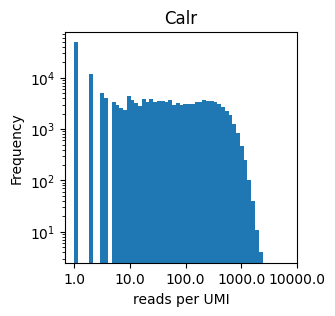

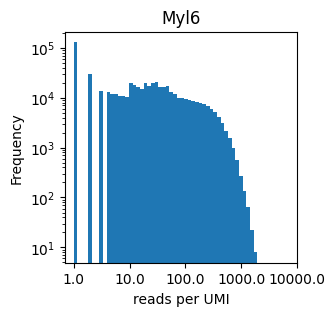

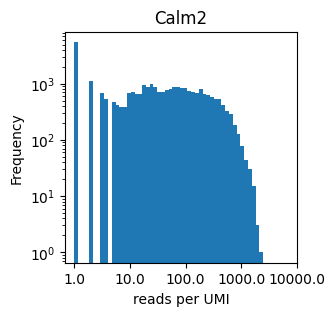

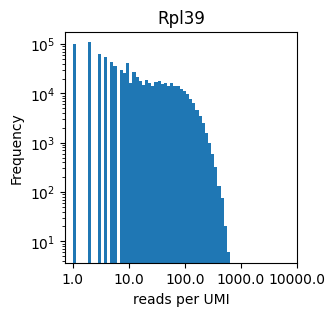

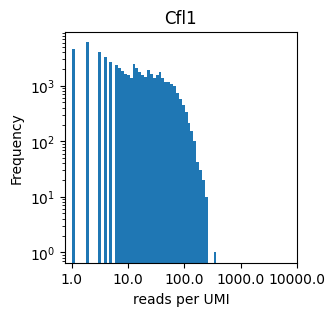

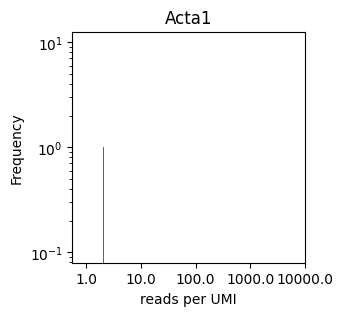

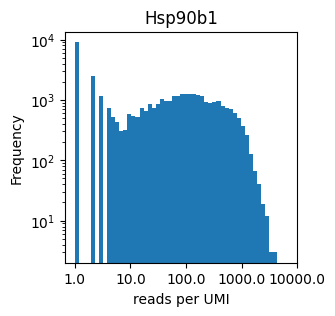

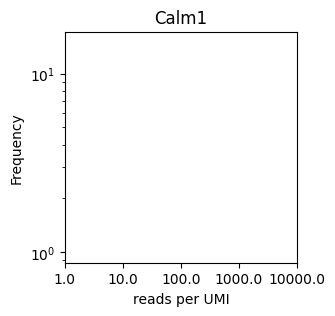

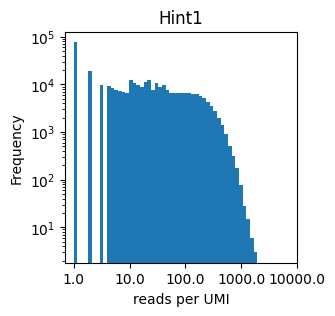

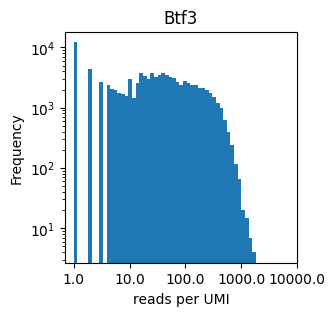

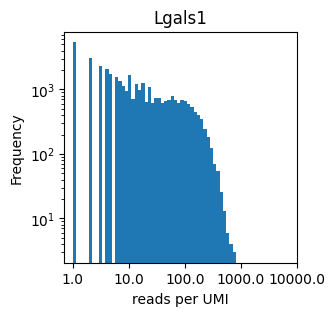

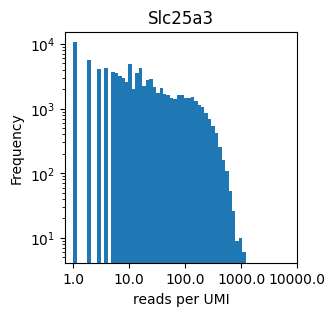

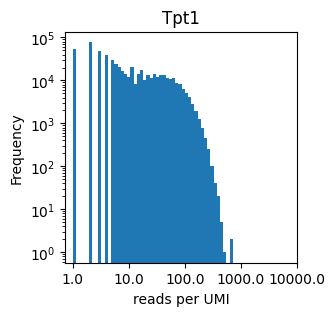

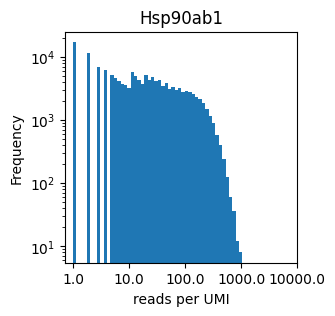

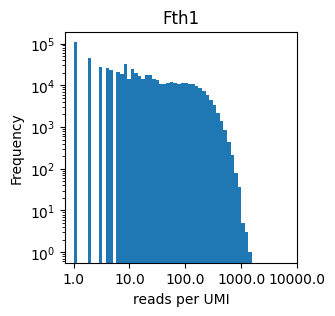

In [703]:
umi_table_all = []

for gene in gene_names:
        umi_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/cassiopeia_result/'+gene+'/'+'umi_table_filtered.csv',
                               sep=',',index_col=0,header=0,keep_default_na=False)
        
        plt.figure(figsize=(3,3))
        plt.hist(np.log(umi_table['readCount'])/np.log(10), bins=50)
        plt.xticks(range(5),np.logspace(0,4,5))
        plt.yscale('log')
        plt.title(gene)
        plt.xlabel('reads per UMI')
        plt.ylabel('Frequency')
        plt.show()
        
        umi_table_all.append(umi_table)
umi_table_df = pd.concat(umi_table_all)


In [704]:
umi_table_df

,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,ReferenceBegin,Seq,UMI,allele,cellBC,indel_length,indel_num,intBC,length_M,r1,readCount,reads_indel_length,reads_indel_num
0,AAAAAAAACCCCTTATGATGCGTTA_CCCTTTCCTC_6,690,80M2D64M,"[[86, 'C>G']]",1,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,CCCTTTCCTC,81:2D,AAAAAAAACCCCTTATGATGCGTTA,2,1,Calr,144,81:2D,6,2,1
1,AAAAAAACCAGCGTCTGAAAAAATA_ACTTGGCACA_327,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,ACTTGGCACA,None,AAAAAAACCAGCGTCTGAAAAAATA,0,0,Calr,144,None,327,0,0
2,AAAAAAACCGCGCTGATTCGAGCCC_CCGCGTCCCA_13,510,82M56D35M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,CCGCGTCCCA,83:56D,AAAAAAACCGCGCTGATTCGAGCCC,56,1,Calr,117,83:56D,13,56,1
3,AAAAAAAGATGCCTCCGACACCTGT_CCTGCCCCGT_132,621,65M40D71M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,CCTGCCCCGT,66:40D,AAAAAAAGATGCCTCCGACACCTGT,40,1,Calr,136,66:40D,132,40,1
4,AAAAAAAGGCGGACAGGATTAATCT_TGTGGAGCTG_38,695,79M6D65M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,TGTGGAGCTG,80:6D,AAAAAAAGGCGGACAGGATTAATCT,6,1,Calr,144,80:6D,38,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612822,TTTTTTTTGGCCTGAAGTCCTTATT_AGGAGTGTAA_1,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,AGGAGTGTAA,None,TTTTTTTTGGCCTGAAGTCCTTATT,0,0,Fth1,144,None,1,0,0
612823,TTTTTTTTGTCTTGTTTCTCCCACG_TAGGAACACT_1,572,60M40D68M,"[[146, 'C>A']]",1,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TAGGAACACT,61:40D,TTTTTTTTGTCTTGTTTCTCCCACG,40,1,Fth1,128,61:40D,1,40,1
612824,TTTTTTTTGTCTTGTTTCTCCCACG_TAGGCACACT_36,699,90M2D54M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TAGGCACACT,91:2D,TTTTTTTTGTCTTGTTTCTCCCACG,2,1,Fth1,144,91:2D,36,2,1
612825,TTTTTTTTTAGTGACCTTGGCTCGG_CAAATCTCGT_7,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,CAAATCTCGT,None,TTTTTTTTTAGTGACCTTGGCTCGG,0,0,Fth1,144,None,7,0,0


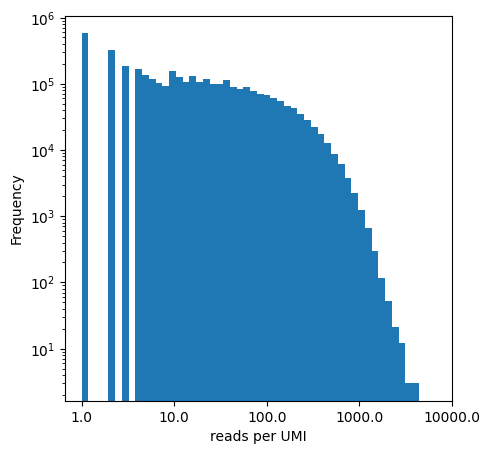

In [705]:
plt.figure(figsize=(5,5))
plt.hist(np.log(umi_table_df['readCount'])/np.log(10), bins=50)
plt.xticks(range(5),np.logspace(0,4,5))
plt.yscale('log')
plt.xlabel('reads per UMI')
plt.ylabel('Frequency')
plt.show()

## filter UMI

In [1450]:
umi_table = umi_table_df.sort_values(by='readCount',ascending=False).groupby(['cellBC','UMI']).head(1)
umi_table = umi_table[umi_table['indel_length'] < 50]
umi_table = umi_table[umi_table['length_M'] > 90]
umi_table = umi_table[umi_table['Mismatch_num'] < 15 ]
umi_table = umi_table[umi_table['readCount'] >= 10 ] 

In [1451]:
umi_table 

,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,ReferenceBegin,Seq,UMI,allele,cellBC,indel_length,indel_num,intBC,length_M,r1,readCount,reads_indel_length,reads_indel_num
1158,AACTGTGTTCACACGACAGATTCGC_CGACCGTACG_4379,690,89M11D55M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,CGACCGTACG,90:11D,AACTGTGTTCACACGACAGATTCGC,11,1,Hsp90b1,144,90:11D,4379,11,1
3803,ACCCTAACACGAGATCCCGTTGACG_TCCCTGCCCA_4297,720,144M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,TCCCTGCCCA,None,ACCCTAACACGAGATCCCGTTGACG,0,0,Hsp90b1,144,None,4297,0,0
26080,GCCTAACCCTAGGCCTTAGGACAAG_ACTTATCTCC_3845,686,87M15D57M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,ACTTATCTCC,88:15D,GCCTAACCCTAGGCCTTAGGACAAG,15,1,Hsp90b1,144,88:15D,3845,15,1
7415,AGCTTAACTCTTCAGATTCGTACAC_CTTGCCTCCC_3664,720,144M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,CTTGCCTCCC,None,AGCTTAACTCTTCAGATTCGTACAC,0,0,Hsp90b1,144,None,3664,0,0
14794,CCCAGCTGGTTAAGCGCCGTTCCCA_CCAGCTTTAT_3579,720,144M,[],0,6,AGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCTACAGAG...,0,ATAGCGAGGGACAGAAGAAGAAGAGGAGGAAACAGAAAAGGAATCT...,CCAGCTTTAT,None,CCCAGCTGGTTAAGCGCCGTTCCCA,0,0,Hsp90b1,144,None,3579,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486647,TCGGACTAATACACGCCGAAGCCAA_ACTTGCCGGT_10,593,72M1D15M18D43M,[],0,6,TGGCTGAGGACATTCTGTATCCCGAGTCTGTTCCTTGCCCAGTGTG...,0,AATCGCTGGCTGAGGACATTCTGTATCCCGAGTCTGTTCCTTGCCC...,ACTTGCCGGT,73:1D89:18D,TCGGACTAATACACGCCGAAGCCAA,19,2,Myl6,130,73:1D89:18D,10,19,2
250791,CACGTTGGTATTGCAAGTAATCGAC_CGTCGGGCGC_10,699,87M2D57M,[],0,6,AGGATTCACACAATGGCAAGACTGAGGATTTATACTGAATTGTCAT...,0,AAGCTCAGGATTCACACAATGGCAAGACTGAGGATTTATACTGAAT...,CGTCGGGCGC,88:2D,CACGTTGGTATTGCAAGTAATCGAC,2,1,Rpl39,144,88:2D,10,2,1
580170,GGGATCACCTTCGAGCAAAGTCATA_TTGGCTTCTG_10,720,144M,[],0,6,AGGATTCACACAATGGCAAGACTGAGGATTTATACTGAATTGTCAT...,0,AAGCTCAGGATTCACACAATGGCAAGACTGAGGATTTATACTGAAT...,TTGGCTTCTG,None,GGGATCACCTTCGAGCAAAGTCATA,0,0,Rpl39,144,None,10,0,0
94915,AGCAACAAAACTTCCTTGGTTTTGG_GTTGCGGCCT_10,720,144M,[],0,6,TGGCTGAGGACATTCTGTATCCCGAGTCTGTTCCTTGCCCAGTGTG...,0,AATCGCTGGCTGAGGACATTCTGTATCCCGAGTCTGTTCCTTGCCC...,GTTGCGGCCT,None,AGCAACAAAACTTCCTTGGTTTTGG,0,0,Myl6,144,None,10,0,0


In [1452]:
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]

intBC_cutSite = pd.concat([pd.DataFrame(data=gene_names,columns=['intBC']),pd.DataFrame(data=cut_sites,columns=['cut_site']),
                          pd.DataFrame(data=wc,columns=['wc'])],axis=1)

In [1453]:
umi_table = pd.merge(intBC_cutSite,umi_table,how='inner',on=['intBC'])

In [1454]:
## constrain cut site in 30bp the left and right of the cutsite location

def filter_based_on_region(edit):
    cut_site = edit[0]
    mark = np.zeros(200)
    r1 = edit[1]
    #print(edit)
    if 'None' in r1:
        return 'passed'
    indels = re.findall(r'(\d+)([MIDNSHP=X])', r1)
    positions = re.findall(r'(\d+)(:)', r1)
    for indel, position in zip(indels,positions):
        #print(position)
        pos = int(position[0])
        if abs(pos-cut_site)<=12: 
            count = int(indel[0])
            mark[pos:pos+count] = 1
        else:
            return 'failed'

    min_pos = np.where(mark==1)[0][0]
    max_pos = np.where(mark==1)[0][-1]
    cut_min = cut_site - 30
    cut_max = cut_site + 30

    if cut_min > min_pos or cut_max < max_pos:
        return 'failed'
    else:
        return 'passed'
    


In [1455]:
umi_table['r1_isvalid'] = umi_table[['cut_site','r1']].apply(filter_based_on_region,axis=1)
umi_table = umi_table[umi_table['r1_isvalid']=='passed']

In [1456]:
umi_table

,intBC,cut_site,wc,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,...,allele,cellBC,indel_length,indel_num,length_M,r1,readCount,reads_indel_length,reads_indel_num,r1_isvalid
0,Calr,80,-17,CCACAGTCCTTAGCTTCGTTGAATT_TTGAAAAAGG_2238,690,77M11D67M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,78:11D,CCACAGTCCTTAGCTTCGTTGAATT,11,1,144,78:11D,2238,11,1,passed
1,Calr,80,-17,ATAGATCCCAGTTATGCTTCCCCTA_CTGTGCCCTG_2184,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,None,ATAGATCCCAGTTATGCTTCCCCTA,0,0,144,None,2184,0,0,passed
2,Calr,80,-17,TTTCCCCACGCGGGGCGGAATAAGA_AAGCGAGATT_2071,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,None,TTTCCCCACGCGGGGCGGAATAAGA,0,0,144,None,2071,0,0,passed
3,Calr,80,-17,ATGCAAGAATCAATATCGCGCGGGA_GCAAGCAGAA_1982,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,None,ATGCAAGAATCAATATCGCGCGGGA,0,0,144,None,1982,0,0,passed
4,Calr,80,-17,CTTGCCAAAGCCATGCACGAGCCTC_GAGCTGACGA_1922,672,73M29D71M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,74:29D,CTTGCCAAAGCCATGCACGAGCCTC,29,1,144,74:29D,1922,29,1,passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749587,Fth1,89,-17,CTTCCTAACGAACAAGCACTCGCGC_TGTTTCACCA_10,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,None,CTTCCTAACGAACAAGCACTCGCGC,0,0,144,None,10,0,0,passed
1749588,Fth1,89,-17,CTAAGCCCCGTAACAGCCCCGGGTC_AGCTCCACCC_10,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,None,CTAAGCCCCGTAACAGCCCCGGGTC,0,0,144,None,10,0,0,passed
1749590,Fth1,89,-17,CTGCGCTGCTTTCCGCGTTCCCACC_TTTTTTTTTT_10,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,None,CTGCGCTGCTTTCCGCGTTCCCACC,0,0,144,None,10,0,0,passed
1749591,Fth1,89,-17,GAGACGCATGGCGACCTTATCAGAC_TCATATTTGT_10,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,None,GAGACGCATGGCGACCTTATCAGAC,0,0,144,None,10,0,0,passed


In [ ]:
barcodeToPos_df = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/barcodeToPos.txt',sep='\t',header=None)
barcodeToPos_df.columns = ['CID','x','y']
barcodeToPos_df['x_y'] = barcodeToPos_df['x'].astype('str') + '_' + barcodeToPos_df['y'].astype('str')
barcodeToPos_dict = barcodeToPos_df.set_index('CID')['x_y'].to_dict()

In [1457]:
umi_table['x_y'] = [ barcodeToPos_dict[CID] for CID in umi_table['cellBC'] ]

In [ ]:
gem = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/B03203C612.tissue.bin50.gem',
            sep='\t',header=0)
gem.columns = ['geneID','x','y','MIDCount','ExonCount','bin50_x','bin50_y','CellID']
gem['CellID'] = gem['CellID'].astype('str')
gem['x_y'] = gem['x'].astype('str') + '_' + gem['y'].astype('str')
gem = gem.drop_duplicates(subset='x_y',keep='first')

In [1458]:
umi_table = pd.merge(umi_table,gem,on='x_y',how='left')
umi_table = umi_table.dropna(axis=0,subset = ['CellID']) 

In [1459]:
umi_table

,intBC,cut_site,wc,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,...,r1_isvalid,x_y,geneID,x,y,MIDCount,ExonCount,bin50_x,bin50_y,CellID
0,Calr,80,-17,CCACAGTCCTTAGCTTCGTTGAATT_TTGAAAAAGG_2238,690,77M11D67M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,6427_11487,Calr,6427.0,11487.0,3.0,3.0,6400.0,11450.0,6400_11450
1,Calr,80,-17,ATAGATCCCAGTTATGCTTCCCCTA_CTGTGCCCTG_2184,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,7323_9699,Calr,7323.0,9699.0,4.0,4.0,7300.0,9650.0,7300_9650
2,Calr,80,-17,TTTCCCCACGCGGGGCGGAATAAGA_AAGCGAGATT_2071,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,4987_6376,Calr,4987.0,6376.0,2.0,2.0,4950.0,6350.0,4950_6350
3,Calr,80,-17,ATGCAAGAATCAATATCGCGCGGGA_GCAAGCAGAA_1982,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,9018_6144,Calr,9018.0,6144.0,1.0,1.0,9000.0,6100.0,9000_6100
4,Calr,80,-17,CTTGCCAAAGCCATGCACGAGCCTC_GAGCTGACGA_1922,672,73M29D71M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,...,passed,6496_6107,Calr,6496.0,6107.0,1.0,1.0,6450.0,6100.0,6450_6100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675190,Fth1,89,-17,CGAAACGCTGATAAGGCTCTCGAGT_TGAATAGTCG_10,678,79M23D65M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,3860_3493,Fth1,3860.0,3493.0,1.0,1.0,3850.0,3450.0,3850_3450
1675191,Fth1,89,-17,CTTCCTAACGAACAAGCACTCGCGC_TGTTTCACCA_10,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,10839_7835,Ccnb1,10839.0,7835.0,2.0,2.0,10800.0,7800.0,10800_7800
1675192,Fth1,89,-17,CTAAGCCCCGTAACAGCCCCGGGTC_AGCTCCACCC_10,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,11389_7849,Hnrnpk,11389.0,7849.0,2.0,2.0,11350.0,7800.0,11350_7800
1675193,Fth1,89,-17,CTGCGCTGCTTTCCGCGTTCCCACC_TTTTTTTTTT_10,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,...,passed,10409_4533,Mndal,10409.0,4533.0,2.0,2.0,10400.0,4500.0,10400_4500


In [1460]:
allele_table = (
    umi_table.groupby(["CellID", "intBC", "r1",'allele'])
    .agg({"readCount": "sum", "UMI": "count"})
    .reset_index()
    .sort_values(["UMI", "readCount"], ascending=False)
)


allele_table['UMI_ratio'] = allele_table['UMI'] / allele_table.groupby(["CellID", "intBC"])['UMI'].transform('sum')
allele_table = allele_table[allele_table['UMI'] >= 1]

In [1461]:
allele_table.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table_unfiltered.csv',index=False)

In [1462]:
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio
205466,3350_9100,Fth1,None,None,7700,90,1.000000
209703,3400_9100,Fth1,None,None,5283,57,0.966102
209725,3400_9150,Fth1,None,None,5013,51,0.944444
181788,3050_9600,Fth1,None,None,4803,45,0.957447
209681,3400_9050,Fth1,None,None,4189,44,0.977778
...,...,...,...,...,...,...,...
638309,9950_8800,Lgals1,51:1I,51:1I,10,1,0.500000
638395,9950_9000,Rpl39,85:17D,85:17D,10,1,0.062500
638584,9950_9450,Myl6,88:16D,88:16D,10,1,0.200000
638588,9950_9450,Rpl39,87:1D,87:1D,10,1,0.076923


In [1463]:
len(set(allele_table['CellID']))

35416

In [1464]:
allele_table['num'] = 1

In [1465]:
def edit_matrix_make(gene_edit_info):
    gene_edit_info.index = range(0,gene_edit_info.shape[0])
    edit_matrix = np.zeros([gene_edit_info.shape[0],150])

    for i in range(0,gene_edit_info.shape[0]):
        allele = gene_edit_info['r1'][i]
        
        if allele == 'None':
            edit_matrix[i,:] = 2
            continue
        
        indels = re.findall(r'(\d+)([MIDNSHP=X])', allele)
        positions = re.findall(r'(\d+)(:)', allele)
        for indel, pos in zip(indels,positions):
            #print(pos)
            count = int(indel[0])
            pos = int(pos[0])
            if indel[1] == 'I':    
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = 1
            if indel[1] == 'D':
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = -1


    return edit_matrix

<Figure size 600x600 with 0 Axes>

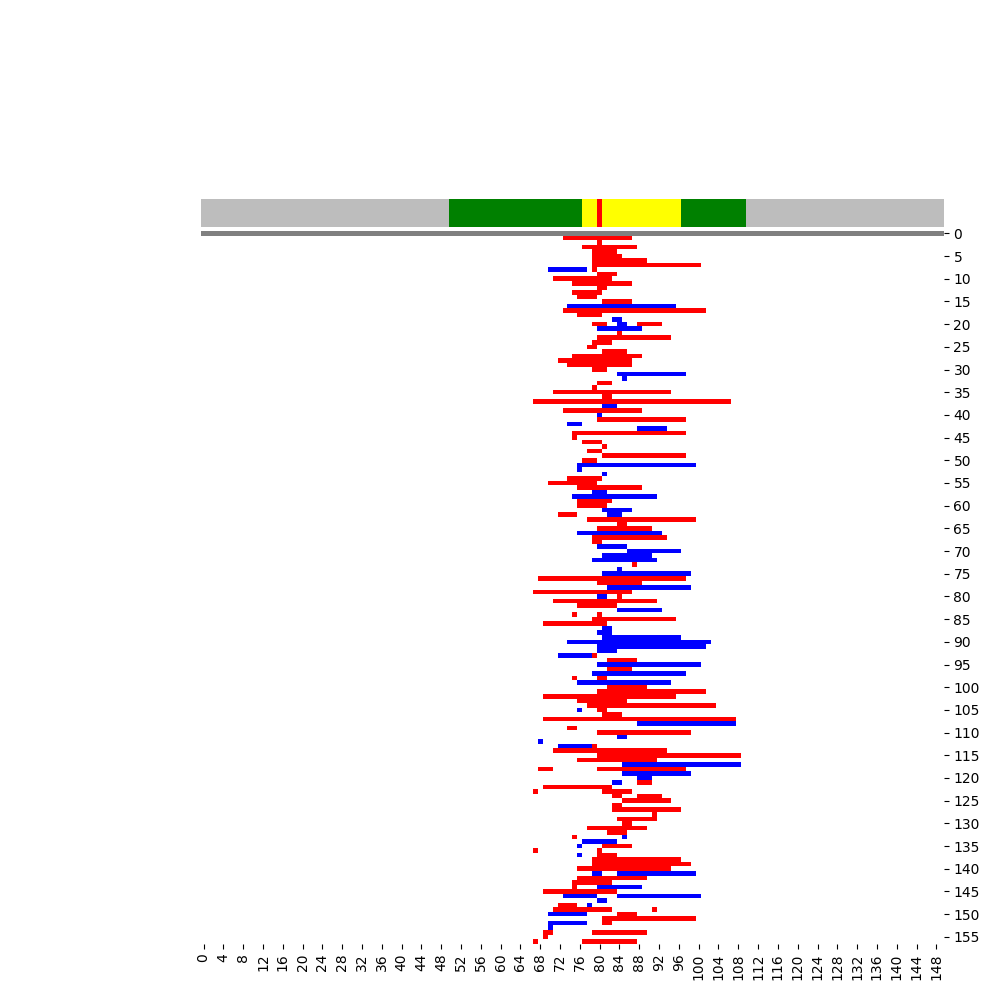

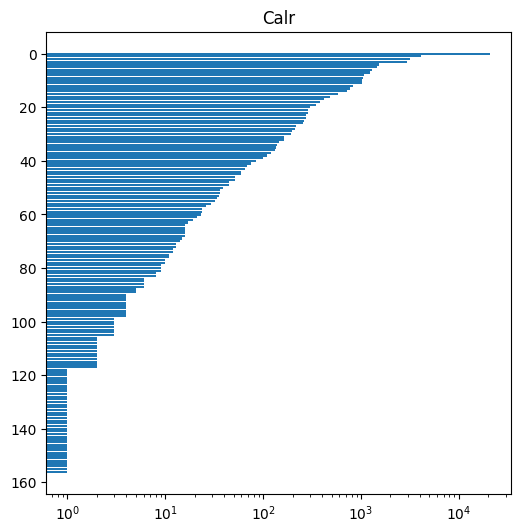

<Figure size 600x600 with 0 Axes>

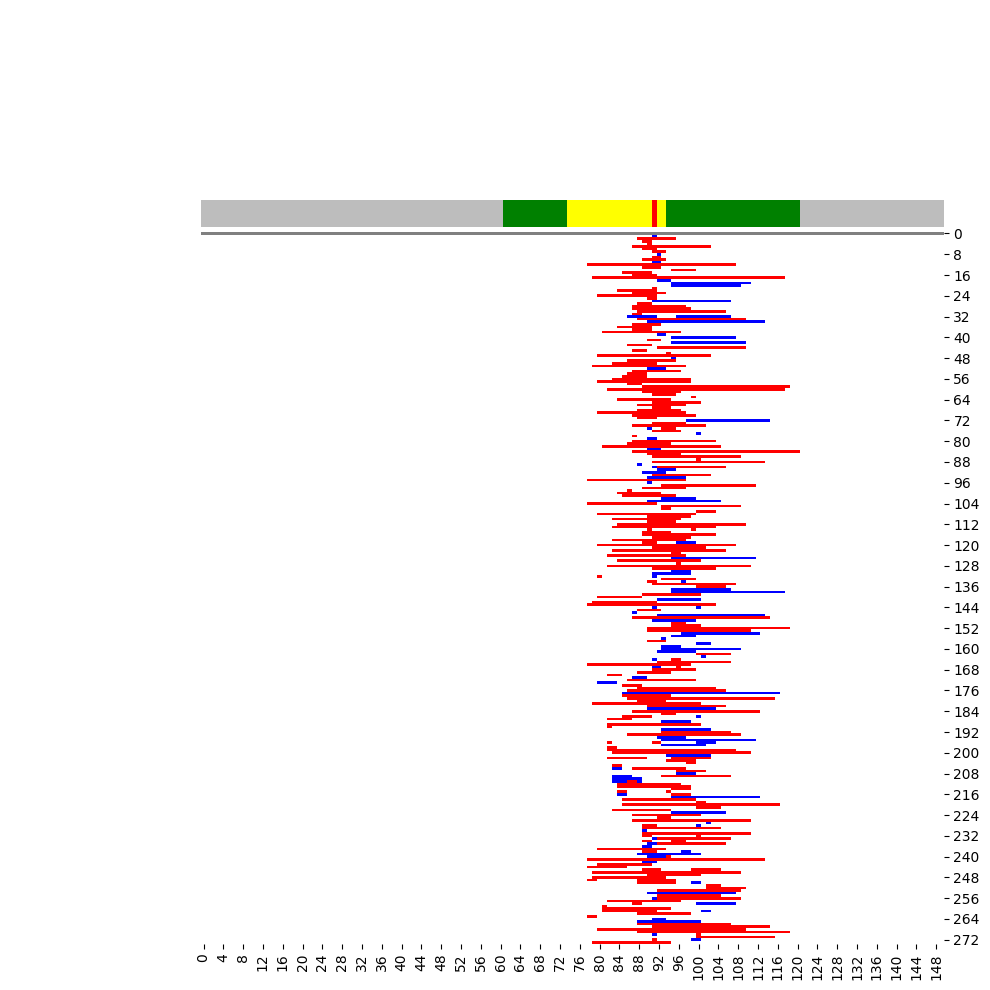

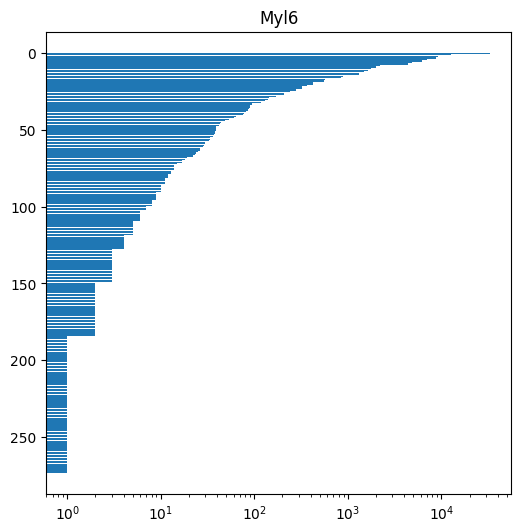

<Figure size 600x600 with 0 Axes>

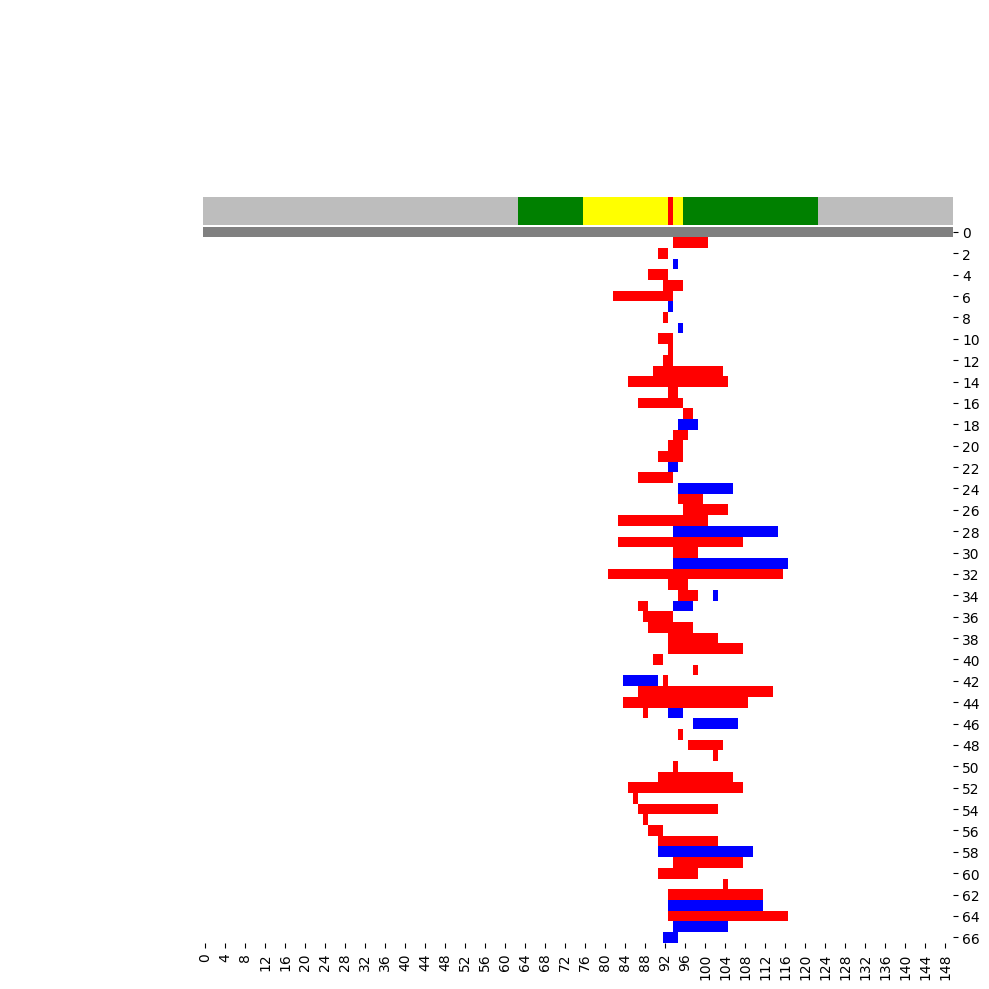

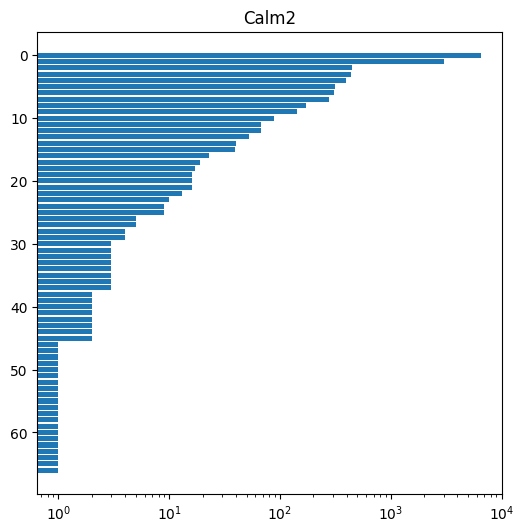

<Figure size 600x600 with 0 Axes>

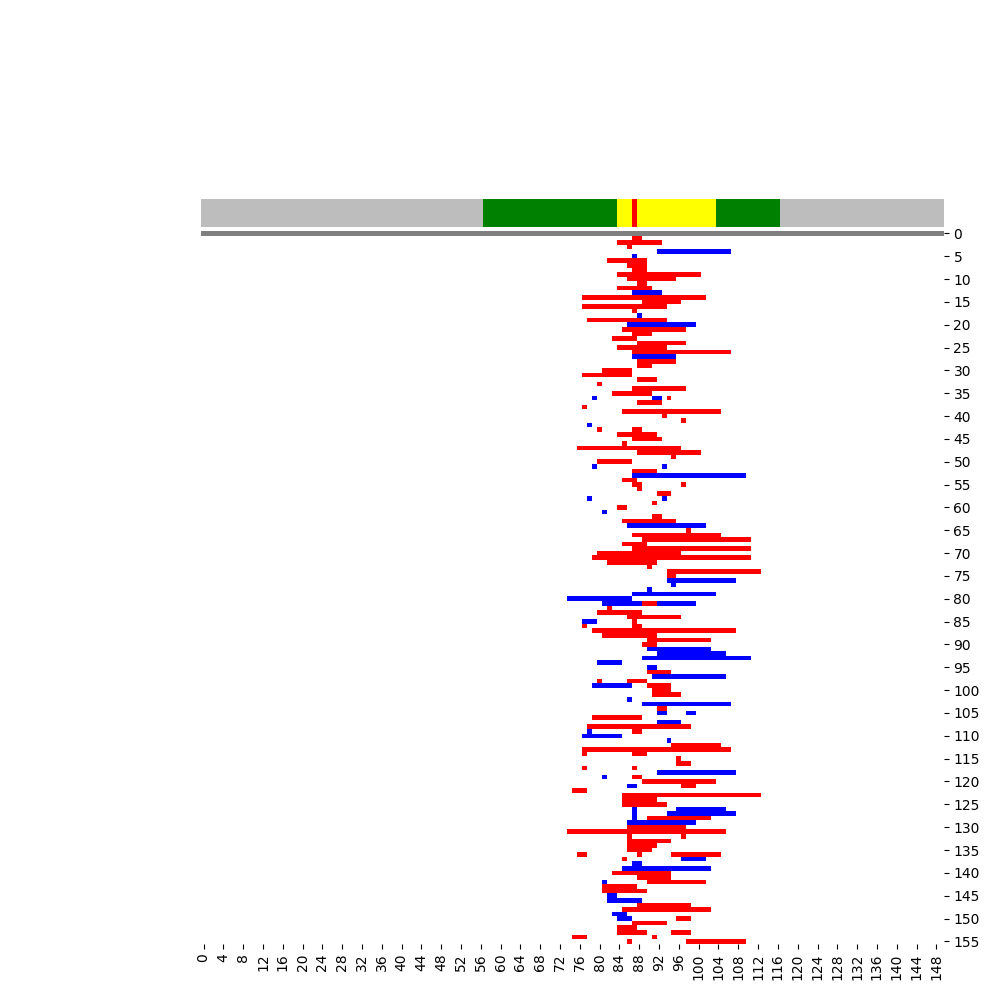

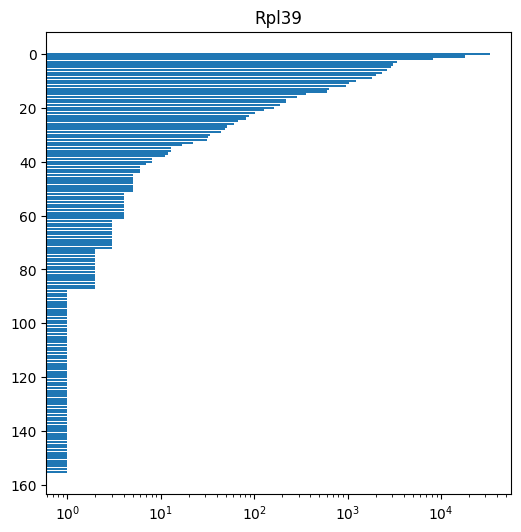

<Figure size 600x600 with 0 Axes>

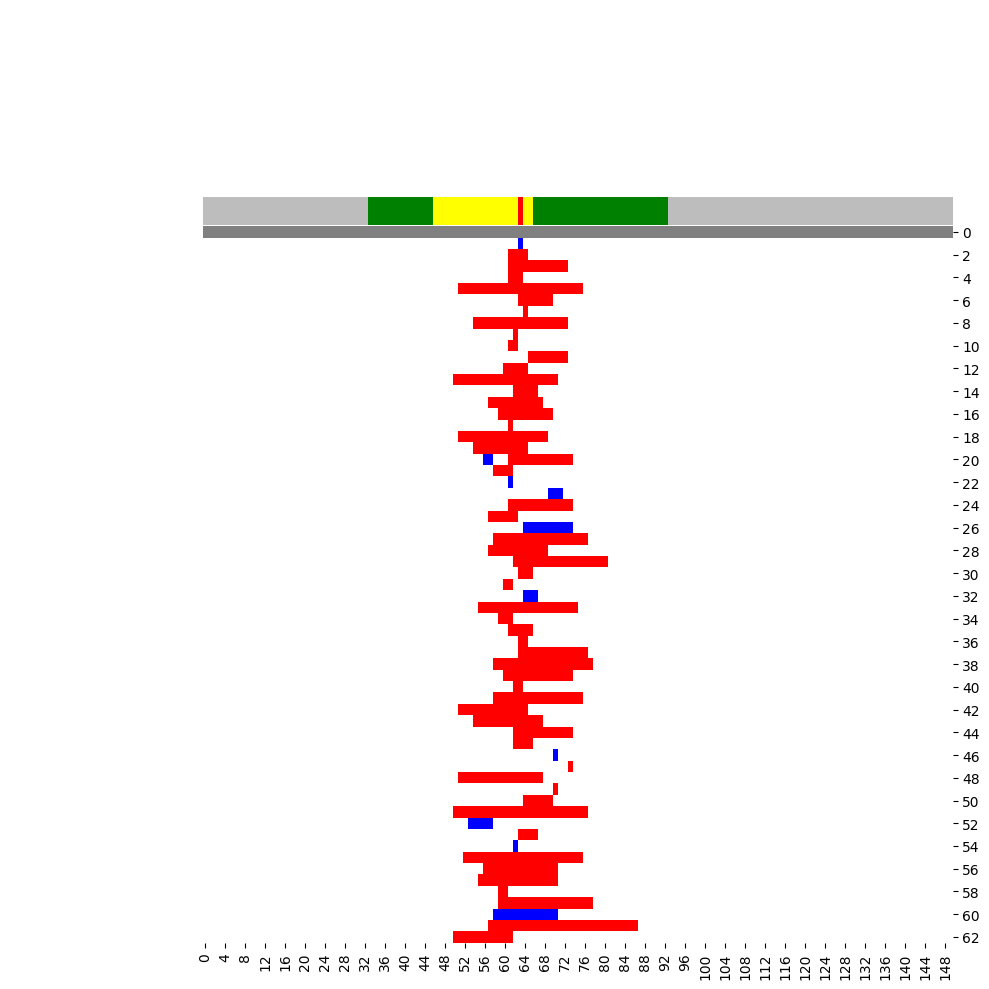

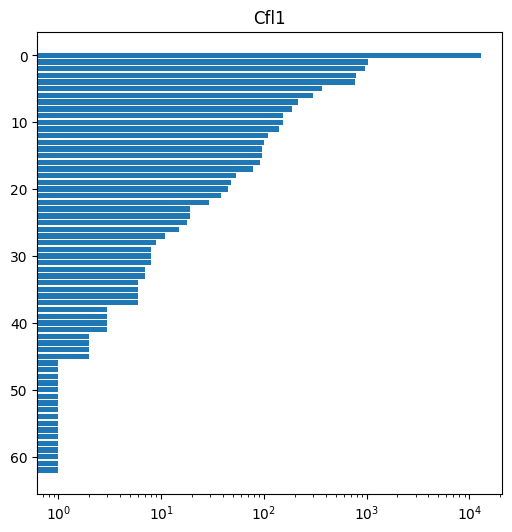

<Figure size 600x600 with 0 Axes>

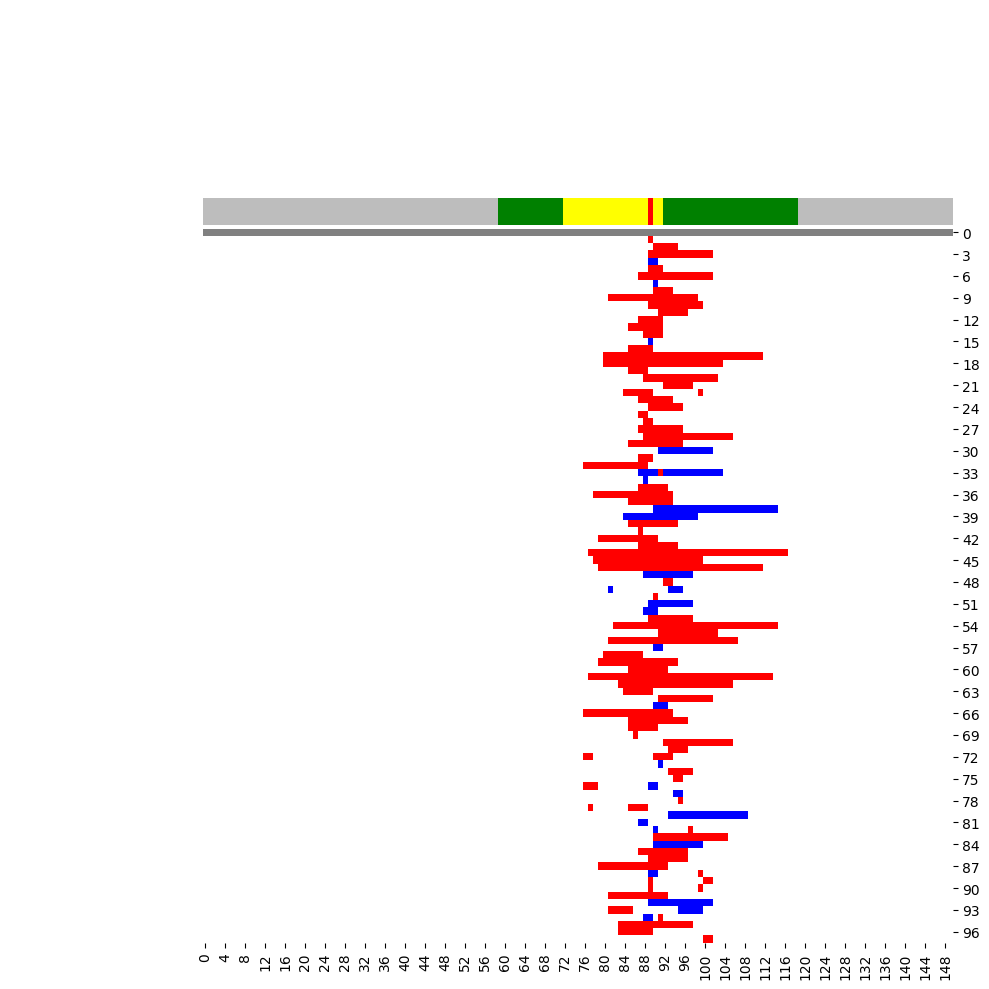

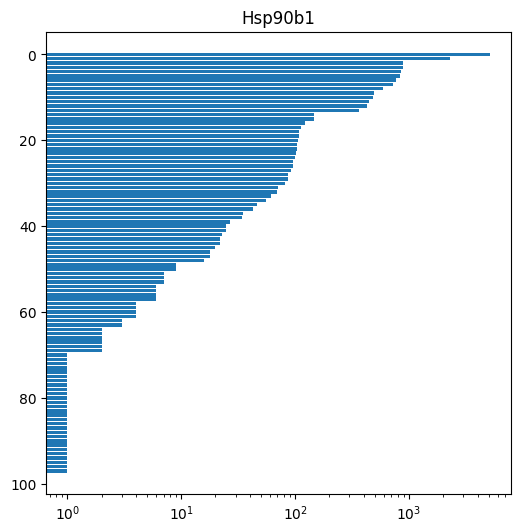

<Figure size 600x600 with 0 Axes>

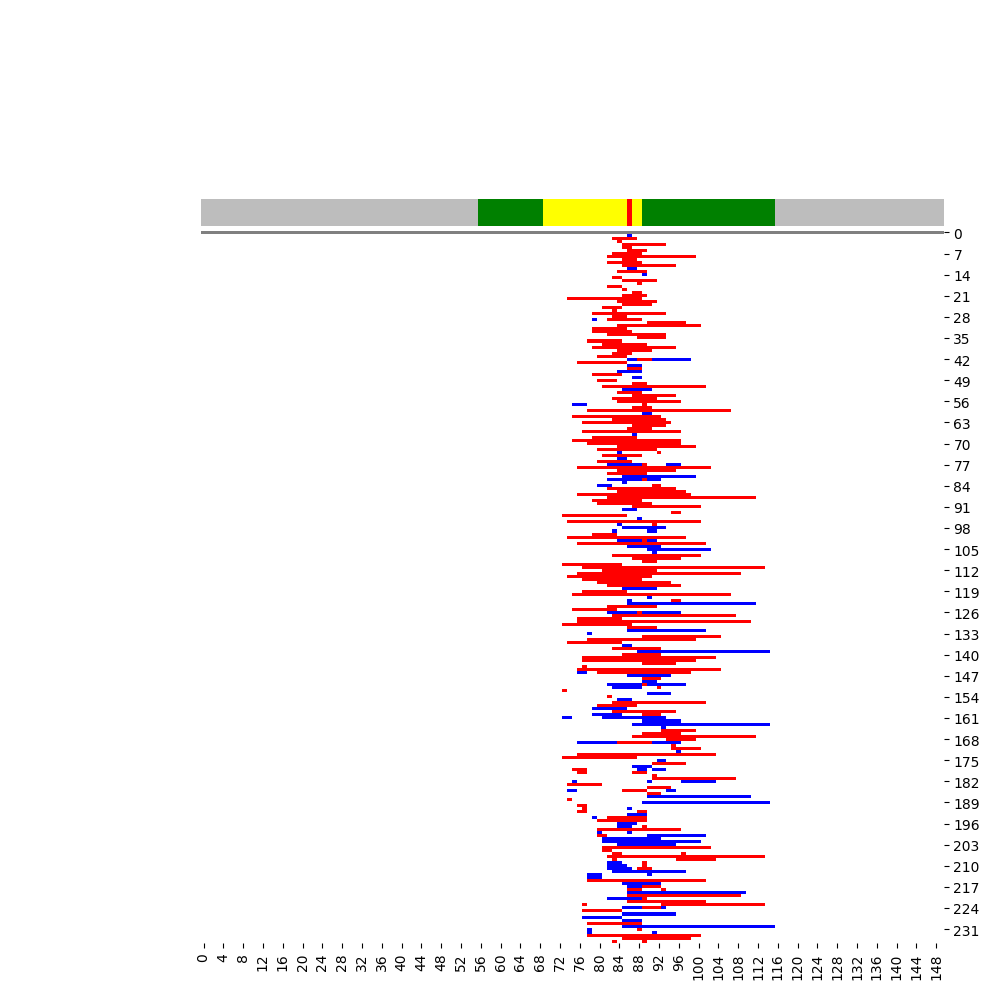

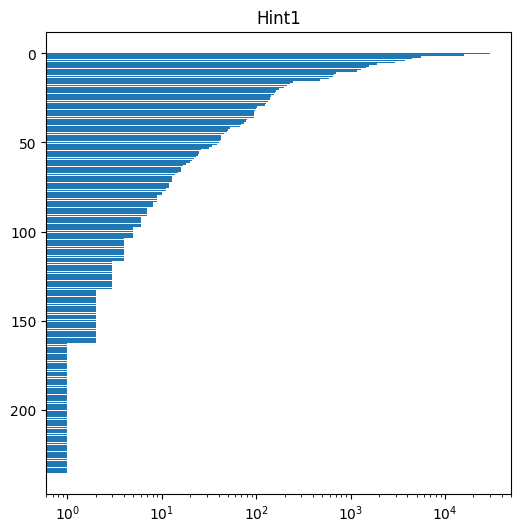

<Figure size 600x600 with 0 Axes>

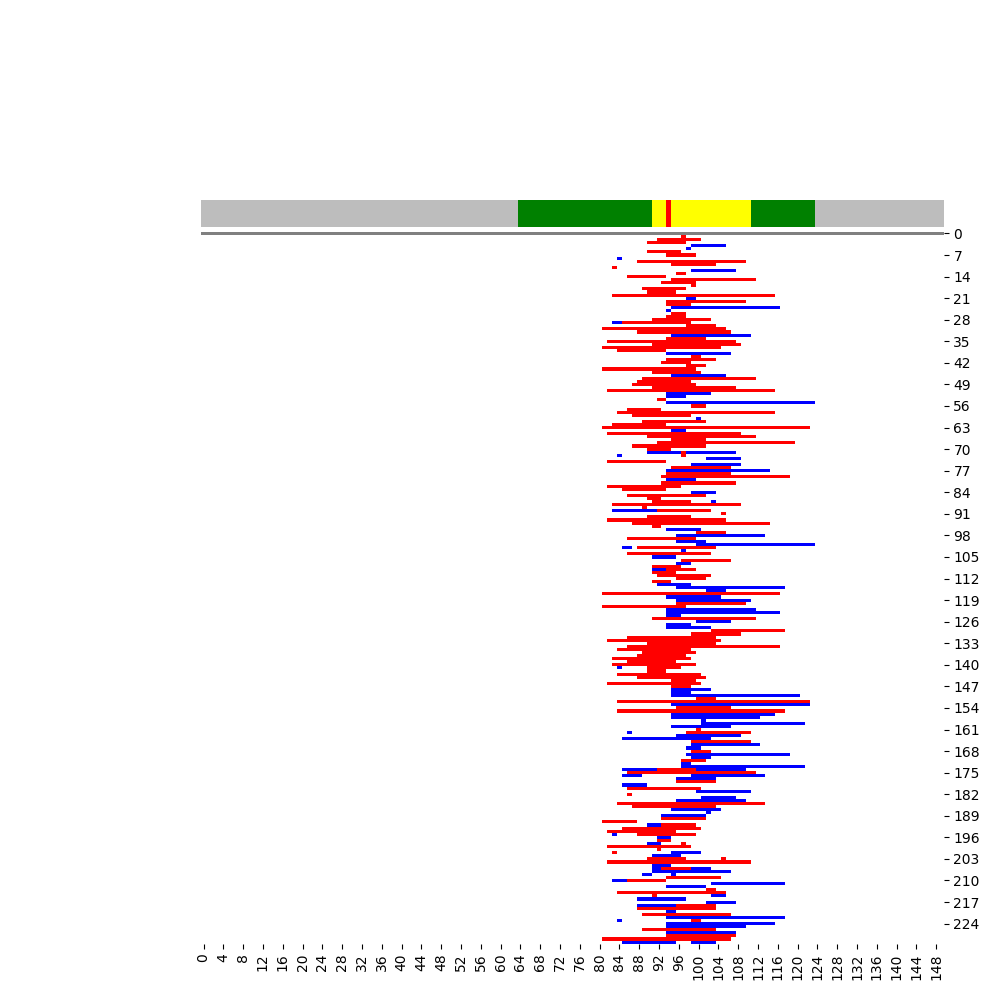

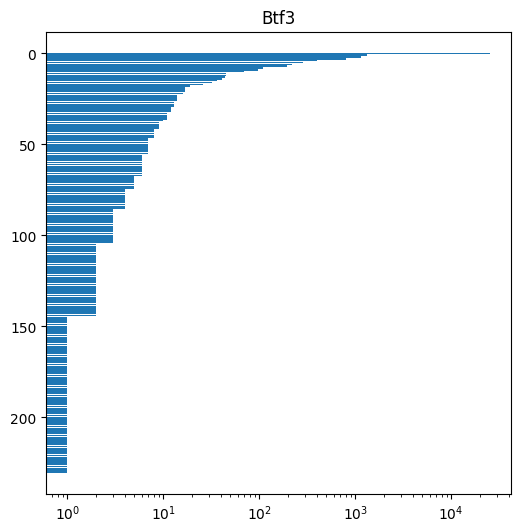

<Figure size 600x600 with 0 Axes>

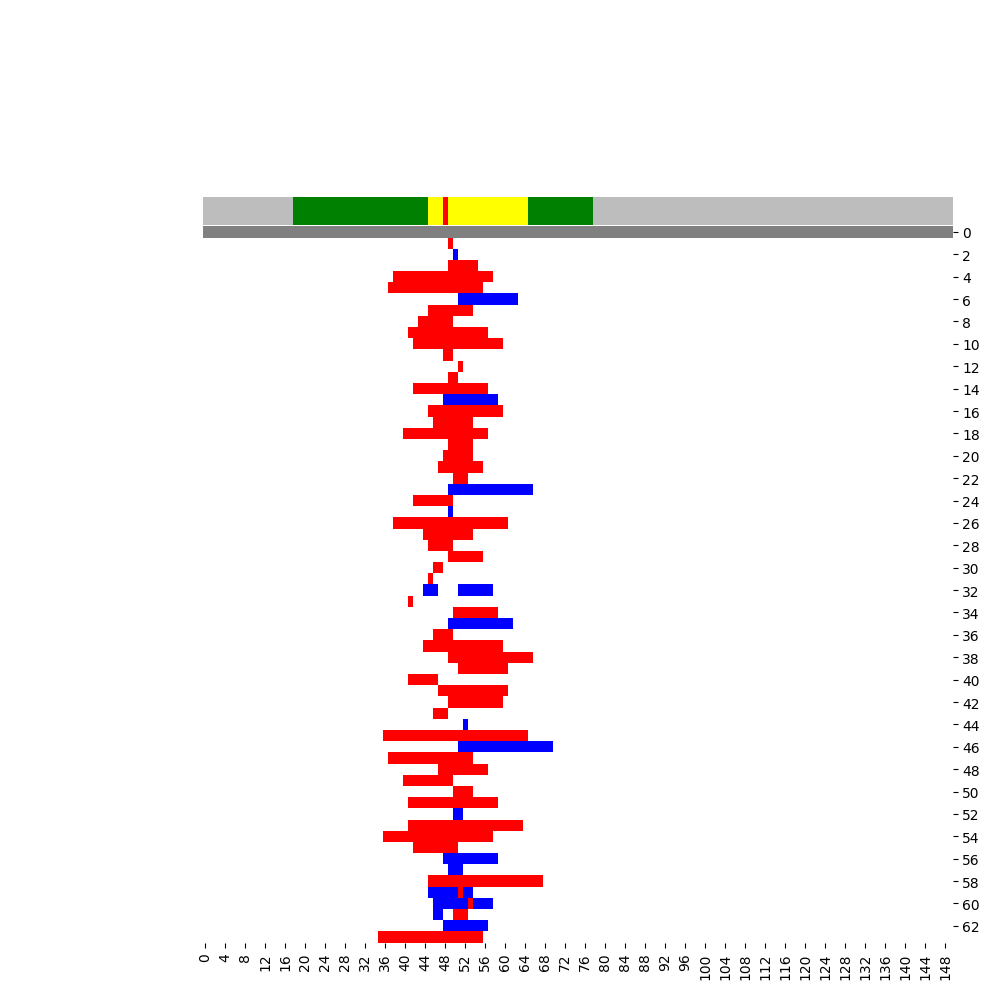

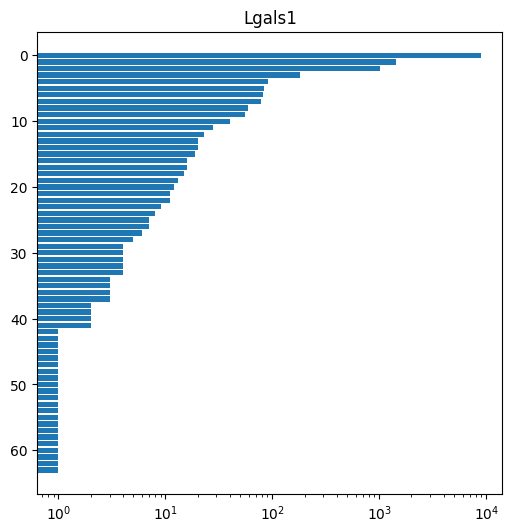

<Figure size 600x600 with 0 Axes>

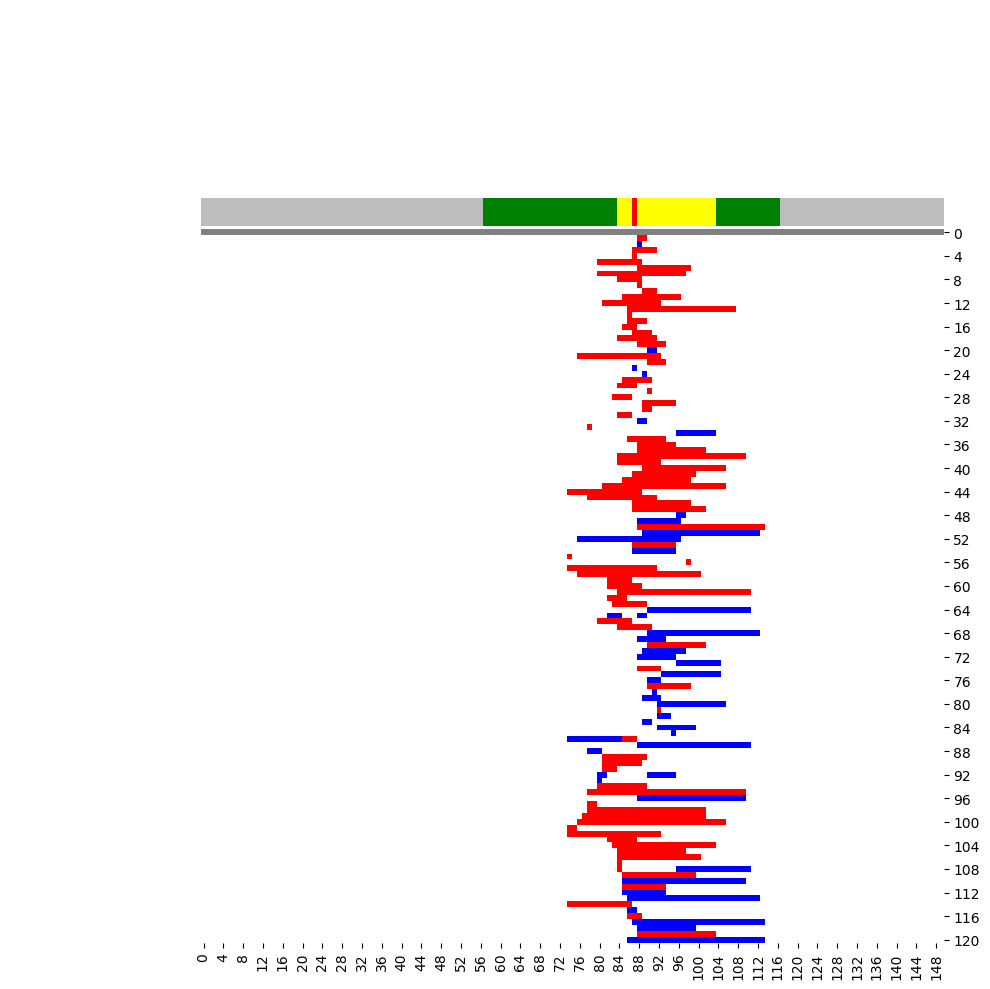

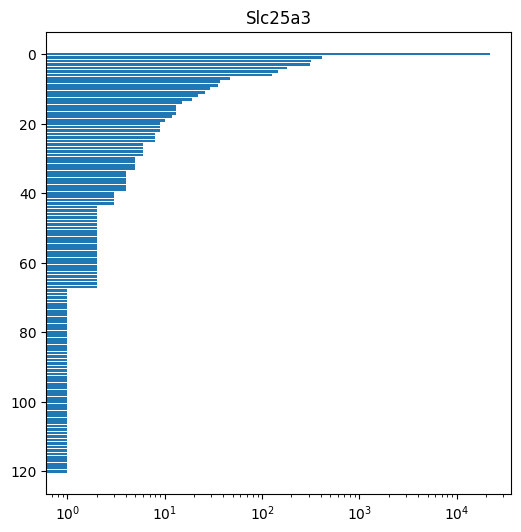

<Figure size 600x600 with 0 Axes>

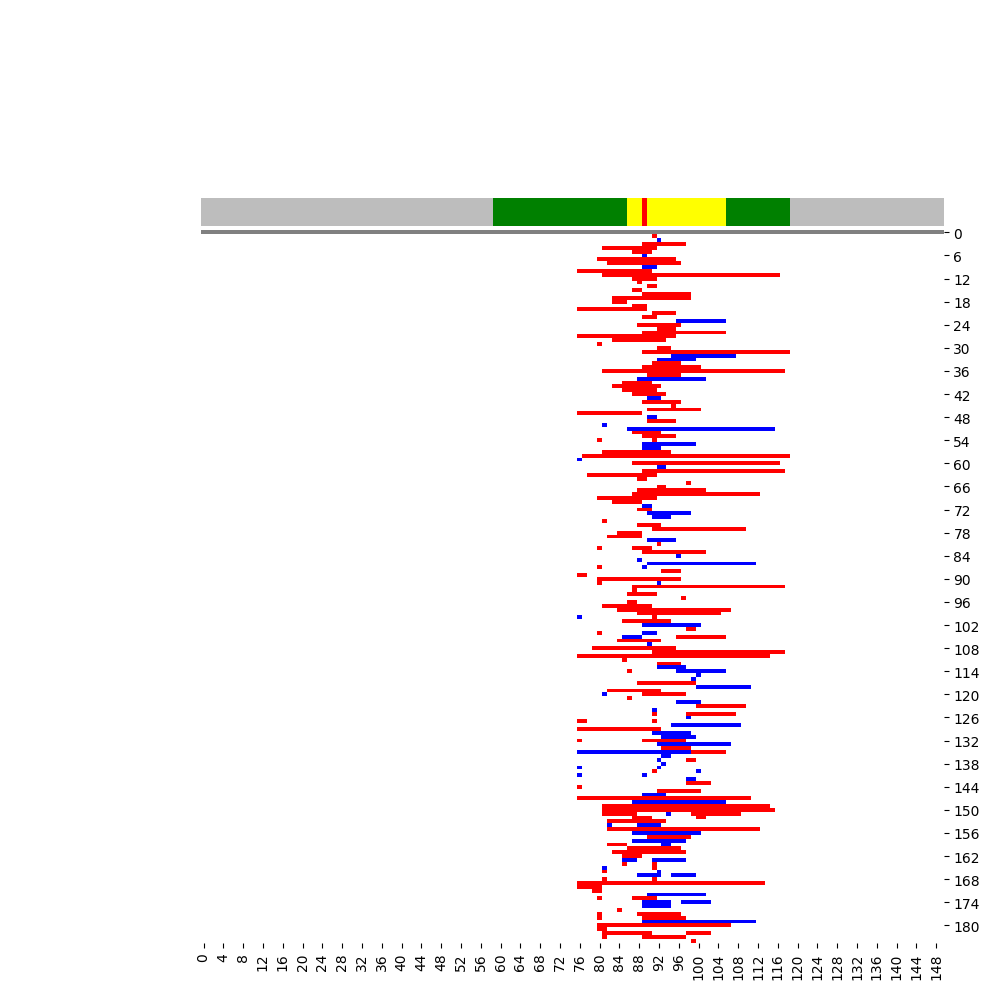

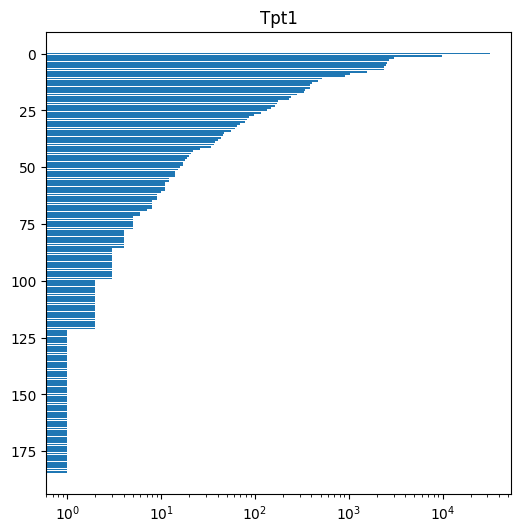

<Figure size 600x600 with 0 Axes>

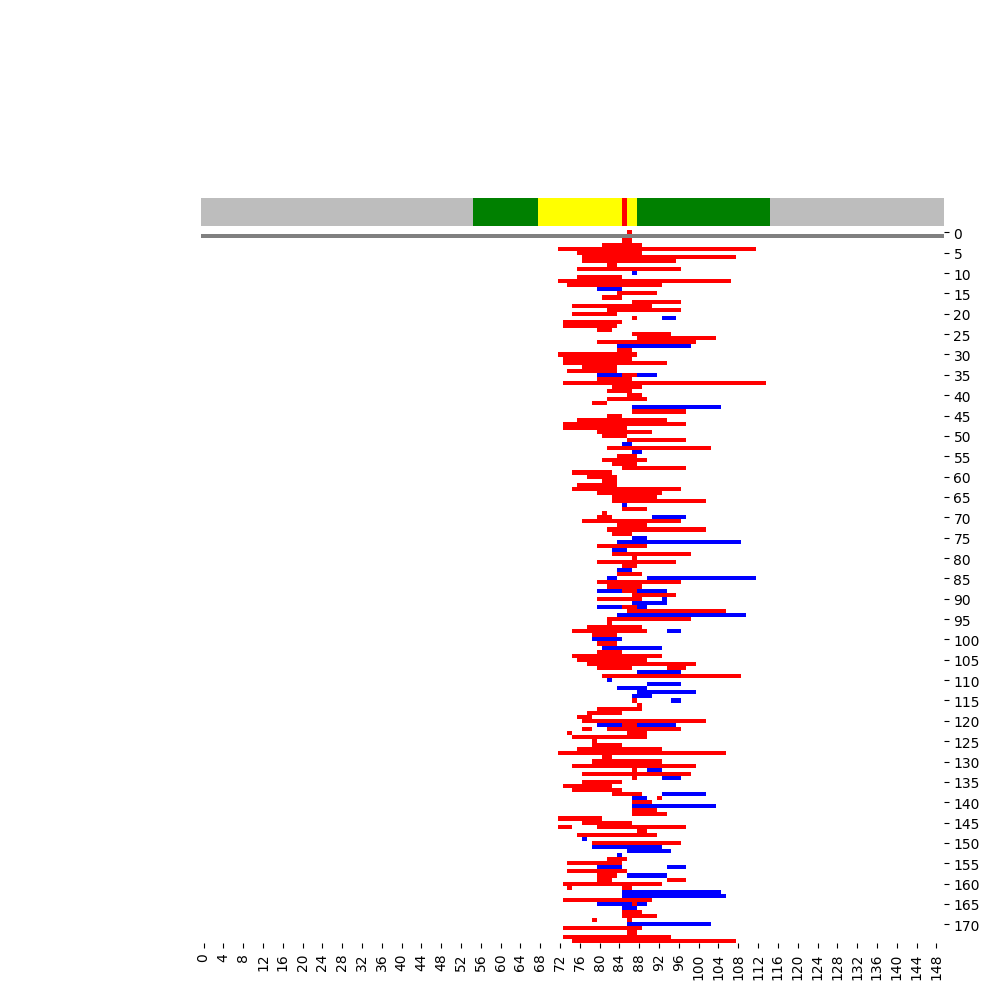

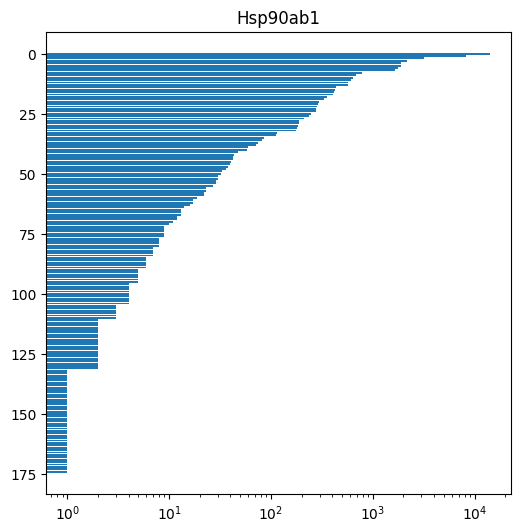

<Figure size 600x600 with 0 Axes>

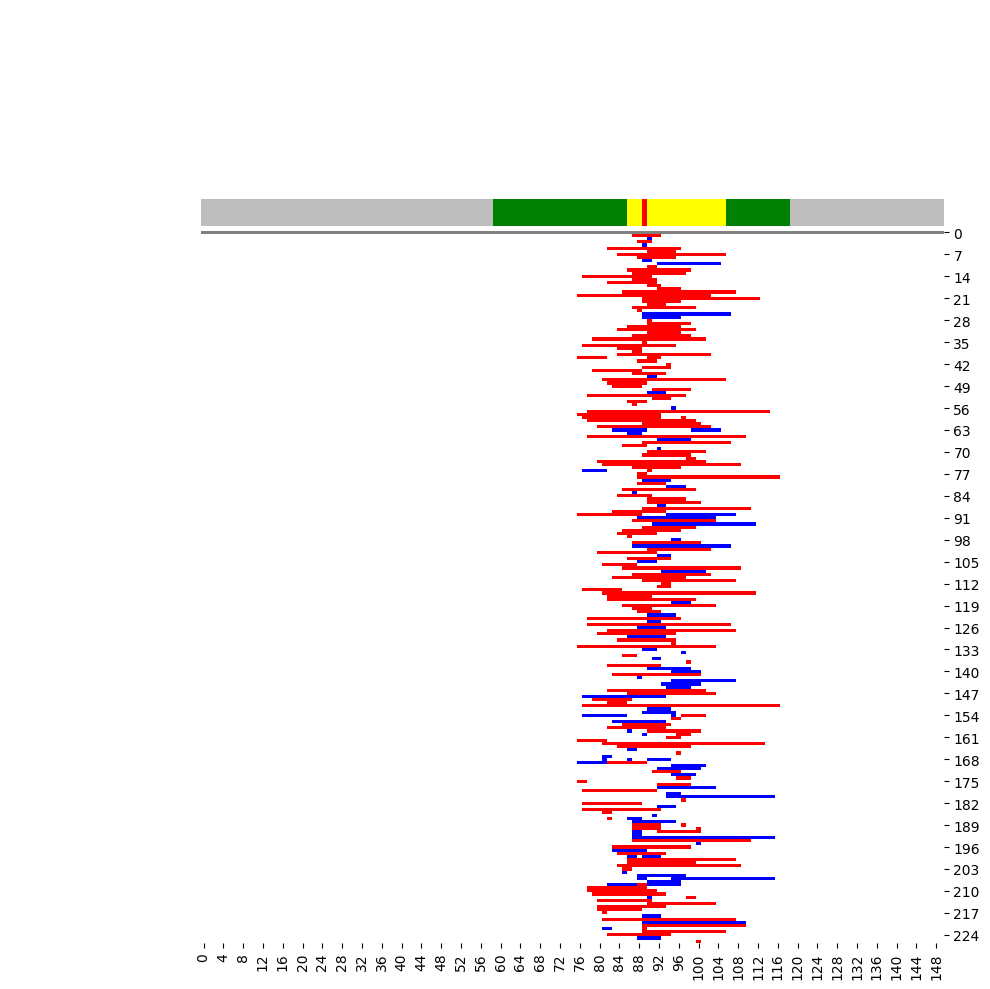

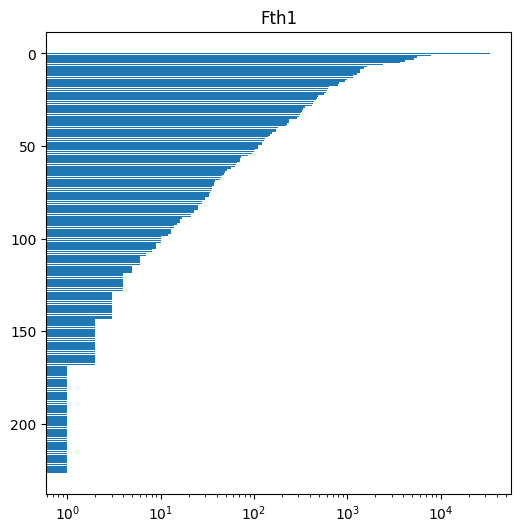

In [1466]:
edit_num = []

edit_info = allele_table
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]

counter = 0
for intBC in gene_names:
    if intBC in ['Calm1','Acta1']:
        counter += 1
        continue
    gene_edit_info = edit_info[edit_info['intBC']==intBC]
    #gene_edit_info['num'] = 1
    gene_edit_info = gene_edit_info.groupby(['r1'])['num'].sum().reset_index().sort_values(by='num',ascending=False)
    gene_edit_indel_info = gene_edit_info.groupby(['r1'])['num'].sum().reset_index().sort_values(by='num',ascending=False)
    edit_num.append((intBC,gene_edit_indel_info.shape[0]-1))
    
    edit_matrix = edit_matrix_make(gene_edit_info)

    colors = {0:'white', 1: 'blue', -1:'red',2:'gray'}
    color_array = [colors[i] for i in range(min(colors.keys()), max(colors.keys()) + 1)]
    cmap = ListedColormap(color_array)
    plt.figure(figsize=(6, 6))
    data_colors = []
    if wc[counter] == -17:
        sgRNA_binding_region = range(cut_sites[counter]-3,cut_sites[counter]+17)
    else:
        sgRNA_binding_region = range(cut_sites[counter]-17,cut_sites[counter]+3)
    
    cut_site_region = range(cut_sites[counter]-30,cut_sites[counter]+30)
    for i in range(0,150):
        if i == cut_sites[counter]:
            data_colors.append('red')
        elif i in sgRNA_binding_region:
            data_colors.append('yellow')
        elif i in cut_site_region:
            data_colors.append('green')
        else:
            data_colors.append('#bdbdbd')
    ax = sns.clustermap(edit_matrix, cmap=cmap,row_cluster=False,col_cluster=False,col_colors=data_colors)
    ax.cax.set_visible(False)
    plt.title(intBC)
    plt.show()
    
    plt.figure(figsize=(6, 6))
    plt.barh(gene_edit_info.index, gene_edit_info['num'])
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.title(intBC)
    plt.show()
    
    counter += 1

## indel_ratio

In [1467]:
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,num
205466,3350_9100,Fth1,None,None,7700,90,1.000000,1
209703,3400_9100,Fth1,None,None,5283,57,0.966102,1
209725,3400_9150,Fth1,None,None,5013,51,0.944444,1
181788,3050_9600,Fth1,None,None,4803,45,0.957447,1
209681,3400_9050,Fth1,None,None,4189,44,0.977778,1
...,...,...,...,...,...,...,...,...
638309,9950_8800,Lgals1,51:1I,51:1I,10,1,0.500000,1
638395,9950_9000,Rpl39,85:17D,85:17D,10,1,0.062500,1
638584,9950_9450,Myl6,88:16D,88:16D,10,1,0.200000,1
638588,9950_9450,Rpl39,87:1D,87:1D,10,1,0.076923,1


In [1468]:
allele_table['allele'].value_counts()

allele
None            272509
88:2D            18961
87:1D            17557
87:1I            15941
92:1I            12603
                 ...  
80:2I85:16I          1
86:4I100:15I         1
101:10D              1
75:1D86:2D           1
90:4D100:6D          1
Name: count, Length: 1239, dtype: int64

Text(0.5, 0, '')

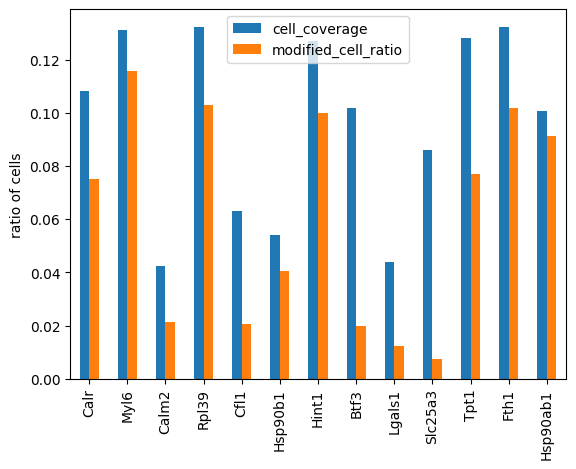

In [1469]:
from collections import Counter
def call_cell_edit_ratio(edit_info,cell_num):
    cell_edited_ratio = []
    for intBC in set(edit_info['intBC']):  
        gene_edit_info = edit_info[edit_info['intBC']==intBC]
        gene_edit_info.index = range(0,gene_edit_info.shape[0])
        detected_cell = []
        modified_cell = []
        for i in range(0,gene_edit_info.shape[0]):
            if gene_edit_info.iloc[i,2] != 'None':
                modified_cell.append(gene_edit_info.iloc[i,0])
            detected_cell.append(gene_edit_info.iloc[i,0])
        two_copy_modified_cell_num = len([value for value in Counter(modified_cell).values() if value==2])
        cell_edited_ratio.append((intBC,len(set(detected_cell))/cell_num,len(set(modified_cell))/cell_num))
        #print(detected_cell)
    return cell_edited_ratio


edit_info = allele_table
cell_num = 260894
cell_edited_ratio = call_cell_edit_ratio(edit_info,cell_num)


df = pd.DataFrame(cell_edited_ratio,columns=['intBC','cell_coverage','modified_cell_ratio'])
df.index = df.intBC
df = df.loc[['Calr','Myl6','Calm2','Rpl39','Cfl1','Hsp90b1','Hint1','Btf3','Lgals1','Slc25a3','Tpt1','Fth1','Hsp90ab1'],:]

df.plot(kind='bar')
plt.ylabel('ratio of cells')
plt.xlabel('')

## mutation number per cell

<Axes: ylabel='mut_num'>

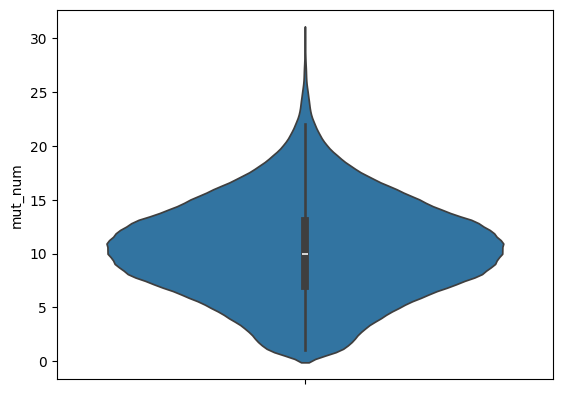

In [1535]:
allele_table = allele_table[allele_table['r1']!='None']
allele_table['mut_num'] = 1
mutation_num = allele_table.groupby(['CellID'])['mut_num'].sum().reset_index()
sns.violinplot(mutation_num,y="mut_num")

# mutation align with single cell

In [128]:
allele_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table_unfiltered.csv',header=0,na_filter=False)
allele_table = allele_table[allele_table['r1']!='None']
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio
1367,6350_8600,Rpl39,88:2D,88:2D,902,15,0.600000
1859,6900_8950,Rpl39,88:2D,88:2D,1088,14,0.666667
1927,6550_8700,Rpl39,88:2D,88:2D,964,14,0.736842
2212,6900_8100,Rpl39,88:2D,88:2D,654,14,0.666667
2282,6550_9150,Rpl39,88:2D,88:2D,595,14,0.636364
...,...,...,...,...,...,...,...
638806,9950_8800,Lgals1,51:1I,51:1I,10,1,0.500000
638807,9950_9000,Rpl39,85:17D,85:17D,10,1,0.062500
638808,9950_9450,Myl6,88:16D,88:16D,10,1,0.200000
638809,9950_9450,Rpl39,87:1D,87:1D,10,1,0.076923


In [129]:
allele_table_a3026 = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/a3026_allele_table.new.csv',header=0,index_col=0,na_filter=False)
allele_table_a3028 = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/a3028_allele_table.new.csv',header=0,index_col=0,na_filter=False)
allele_table_a3030 = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/a3030_allele_table.new.csv',header=0,index_col=0,na_filter=False)

allele_table_sc = pd.concat([allele_table_a3026,allele_table_a3028,allele_table_a3030],axis=0)
allele_table_sc['time'] = [ sample.split('_')[0] for sample in allele_table_sc['Sample'] ]
#allele_table_sc = allele_table_sc[allele_table_sc['Sample'].isin(['T2_a3026_2', 'T2_a3028_2', 'T2_a3030_2'])]
allele_table_sc = allele_table_sc[allele_table_sc['time']=='T2']
allele_table_sc

,Sample,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp,time
5087,T2_a3026_1,T2_a3026_1_TAACTTCGTGCGAGTA,Tpt1,None,None,2181,457,0.978587,C18,T2
5088,T2_a3026_1,T2_a3026_1_TAACTTCGTGCGAGTA,Rpl39,None,None,1119,218,0.995434,C18,T2
5089,T2_a3026_1,T2_a3026_1_TAACTTCGTGCGAGTA,Btf3,None,None,882,114,1.000000,C18,T2
5090,T2_a3026_1,T2_a3026_1_TAACTTCGTGCGAGTA,Fth1,None,None,329,66,0.694737,C18,T2
5091,T2_a3026_1,T2_a3026_1_TAACTTCGTGCGAGTA,Calm2,None,None,1147,26,0.962963,C18,T2
...,...,...,...,...,...,...,...,...,...,...
496492,T2_a3030_1,T2_a3030_1_TCACTATCATGAAAGT,Myl6,92:1I,92:1I,209,6,0.428571,C46,T2
496493,T2_a3030_1,T2_a3030_1_TCACTATCATGAAAGT,Myl6,None,None,32,5,0.357143,C46,T2
496494,T2_a3030_1,T2_a3030_1_TCACTATCATGAAAGT,Myl6,91:8I,91:8I,22,3,0.214286,C46,T2
496495,T2_a3030_1,T2_a3030_1_TCACTATCATGAAAGT,Rpl39,None,None,11,3,0.272727,C46,T2


In [130]:
spatial_cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv')
spatial_cell_lineage

,CellID,lineageGrp,num,x,y
0,8400_3300,C19,28,8400,3300
1,8850_3250,C19,22,8850,3250
2,8800_3750,C19,22,8800,3750
3,5850_5900,C19,19,5850,5900
4,5850_5700,C19,18,5850,5700
...,...,...,...,...,...
13621,5550_2950,C19,2,5550,2950
13622,5550_3050,C4,2,5550,3050
13623,5550_3200,C19,2,5550,3200
13624,2700_8050,C1,2,2700,8050


In [131]:
allele_table_sub = allele_table[allele_table['CellID'].isin(spatial_cell_lineage['CellID'])]
allele_table_sub

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio
2212,6900_8100,Rpl39,88:2D,88:2D,654,14,0.666667
2282,6550_9150,Rpl39,88:2D,88:2D,595,14,0.636364
2325,6800_8750,Rpl39,88:2D,88:2D,561,14,0.666667
3038,10050_8600,Calr,78:11D,78:11D,738,13,0.866667
3492,7750_8800,Rpl39,88:2D,88:2D,477,13,0.684211
...,...,...,...,...,...,...,...
638797,9950_7050,Myl6,90:3D,90:3D,10,1,0.090909
638798,9950_7200,Rpl39,93:15I,93:15I,10,1,0.111111
638805,9950_8650,Calr,80:5D,80:5D,10,1,1.000000
638808,9950_9450,Myl6,88:16D,88:16D,10,1,0.200000


In [132]:
allele_table_sub = pd.merge(allele_table_sub,spatial_cell_lineage,how='left',on='CellID')
allele_table_sub

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp,num,x,y
0,6900_8100,Rpl39,88:2D,88:2D,654,14,0.666667,C71,3,6900,8100
1,6550_9150,Rpl39,88:2D,88:2D,595,14,0.636364,C19,3,6550,9150
2,6800_8750,Rpl39,88:2D,88:2D,561,14,0.666667,C71,2,6800,8750
3,10050_8600,Calr,78:11D,78:11D,738,13,0.866667,C4,2,10050,8600
4,7750_8800,Rpl39,88:2D,88:2D,477,13,0.684211,C4,2,7750,8800
...,...,...,...,...,...,...,...,...,...,...,...
161290,9950_7050,Myl6,90:3D,90:3D,10,1,0.090909,C4,2,9950,7050
161291,9950_7200,Rpl39,93:15I,93:15I,10,1,0.111111,C19,2,9950,7200
161292,9950_8650,Calr,80:5D,80:5D,10,1,1.000000,C15,3,9950,8650
161293,9950_9450,Myl6,88:16D,88:16D,10,1,0.200000,C48,2,9950,9450


In [140]:
allele_table_sub_filter = pd.DataFrame()
for clone in set(allele_table_sub['lineageGrp']):
    allele_table_clone = allele_table_sub[allele_table_sub['lineageGrp']==clone] 
    allele_table_clone = allele_table_clone[allele_table_clone['r1'].isin(set(allele_table_sc[allele_table_sc['lineageGrp']==clone]['r1']))]
    allele_table_sub_filter = pd.concat([allele_table_sub_filter,allele_table_clone],axis=0)

In [141]:
allele_table_sub_filter

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp,num,x,y
4783,3350_10600,Myl6,90:2D,90:2D,290,3,0.333333,C22,2,3350,10600
6792,5550_9550,Rpl39,88:2D,88:2D,146,3,0.300000,C22,3,5550,9550
9940,5500_9500,Hint1,86:2D,86:2D,532,2,1.000000,C22,2,5500,9500
10823,5550_9550,Hsp90ab1,76:22D,76:22D,405,2,0.666667,C22,3,5550,9550
12795,5550_9550,Hint1,86:2D,86:2D,278,2,0.285714,C22,3,5550,9550
...,...,...,...,...,...,...,...,...,...,...,...
160588,8650_11500,Fth1,87:13D,87:13D,10,1,0.090909,C11,2,8650,11500
160637,8750_10950,Hsp90ab1,75:10D,75:10D,10,1,0.250000,C11,2,8750,10950
160754,9000_10650,Hint1,85:1D,85:1D,10,1,0.142857,C11,2,9000,10650
160915,9250_10650,Hint1,87:1I,87:1I,10,1,0.111111,C11,2,9250,10650


<Axes: ylabel='mut_num'>

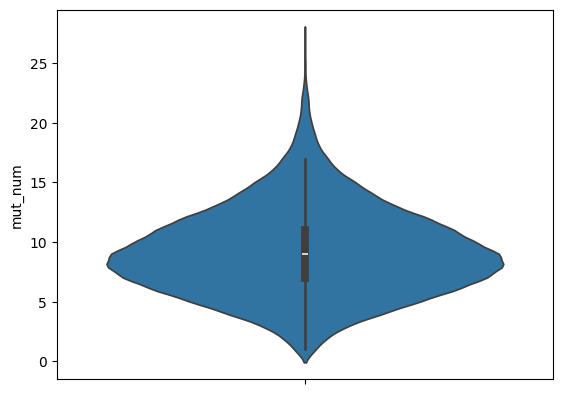

In [142]:
allele_table_sub_filter['mut_num'] = 1
mutation_num = allele_table_sub_filter.groupby(['CellID'])['mut_num'].sum().reset_index()
sns.violinplot(mutation_num,y="mut_num")

In [143]:
#metadata = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/spacia_metadata.txt',index_col=0)
#metadata = metadata.loc[metadata['spot_class'] != 'reject',]
#metadata.index = metadata['x'].astype('str') +'_'+ metadata['y'].astype('str') 
#metadata = metadata[metadata['first_type'].isin(['1','2','3','4','5'])]
#allele_table_sub_filter = allele_table_sub_filter[allele_table_sub_filter['CellID'].isin(metadata.index)]
#allele_table_sub_filter

In [144]:
allele_table_sub_filter.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table_align_to_sc.csv',index=False)

In [145]:
allele_table_sub_filter

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp,num,x,y,mut_num
4783,3350_10600,Myl6,90:2D,90:2D,290,3,0.333333,C22,2,3350,10600,1
6792,5550_9550,Rpl39,88:2D,88:2D,146,3,0.300000,C22,3,5550,9550,1
9940,5500_9500,Hint1,86:2D,86:2D,532,2,1.000000,C22,2,5500,9500,1
10823,5550_9550,Hsp90ab1,76:22D,76:22D,405,2,0.666667,C22,3,5550,9550,1
12795,5550_9550,Hint1,86:2D,86:2D,278,2,0.285714,C22,3,5550,9550,1
...,...,...,...,...,...,...,...,...,...,...,...,...
160588,8650_11500,Fth1,87:13D,87:13D,10,1,0.090909,C11,2,8650,11500,1
160637,8750_10950,Hsp90ab1,75:10D,75:10D,10,1,0.250000,C11,2,8750,10950,1
160754,9000_10650,Hint1,85:1D,85:1D,10,1,0.142857,C11,2,9000,10650,1
160915,9250_10650,Hint1,87:1I,87:1I,10,1,0.111111,C11,2,9250,10650,1


In [146]:
len(set(allele_table_sub_filter['CellID']))

13596

In [149]:
allele_table_sub_filter = allele_table_sub_filter[allele_table_sub_filter['lineageGrp'].isin(['C48','C59','C15','C42','C30'])]

In [150]:
len(set(allele_table_sub_filter['CellID']))

1317

In [151]:
allele_table_sub_filter = allele_table_sub_filter[allele_table_sub_filter['allele']!='None']
allele_table_sub_filter['r1_gene'] = allele_table_sub_filter['intBC'] + '_' + allele_table_sub_filter['r1']
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv',header=0)
cell_lineage.index = cell_lineage.CellID

cell_mutation_matrix = allele_table_sub_filter.pivot(index='CellID', columns='r1_gene', values='UMI')
cell_mutation_matrix = cell_mutation_matrix[cell_mutation_matrix.index.isin(cell_lineage.index )]
cell_mutation_matrix['lineageGrp'] = list(cell_lineage.loc[cell_mutation_matrix.index,'lineageGrp'].astype('str'))
print(cell_mutation_matrix['lineageGrp'].value_counts().index)
cell_mutation_matrix['lineageGrp'] = pd.Categorical(cell_mutation_matrix['lineageGrp'], categories=cell_mutation_matrix['lineageGrp'].value_counts().index, ordered=True)
cell_mutation_matrix = cell_mutation_matrix.sort_values('lineageGrp')
cell_mutation_matrix = cell_mutation_matrix.iloc[:,0:cell_mutation_matrix.shape[1]-1]
cell_mutation_matrix = cell_mutation_matrix.fillna(0)
cell_mutation_matrix[cell_mutation_matrix >0 ] = 1
cell_mutation_matrix = cell_mutation_matrix[cell_mutation_matrix.sum(1) > 4]

cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv')
cell_lineage.index = cell_lineage.CellID
import random
random.seed(0)
color_df = pd.read_csv("/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/color_lineage_dict.new.csv",sep=',',header=0)
color_dict = dict(zip(list(color_df.iloc[:,0].astype('str')), list(color_df.iloc[:,1])))
color_dict['C42'] = '#a6bddb'
color_dict['C59'] = '#1c9099'
data_colors = [color_dict[str(lineageGrp)] for lineageGrp in list(cell_lineage.loc[cell_mutation_matrix.index,'lineageGrp'].astype('str')) ]

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
df_array = cell_mutation_matrix.values
distances = cdist(df_array, df_array, metric='hamming')
result = pd.DataFrame(distances, index=cell_mutation_matrix.index, columns=cell_mutation_matrix.index)
import matplotlib.pyplot as plt

Index(['C48', 'C59', 'C15', 'C42', 'C30'], dtype='object', name='lineageGrp')


<Figure size 500x500 with 0 Axes>

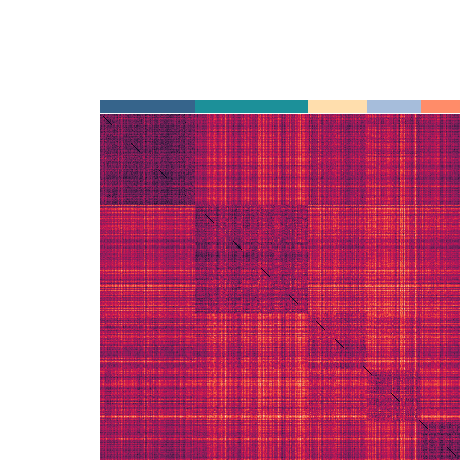

In [156]:
plt.rcParams['pdf.fonttype'] = 42
plt.gcf().set_size_inches(5, 5)
g = sns.clustermap(result,row_cluster=False,col_cluster=False,yticklabels=False,xticklabels=False,col_colors=data_colors,figsize=[5,5],
                  vmin=0,vmax=0.13)
g.ax_heatmap.set_xlabel('')  
g.ax_heatmap.set_ylabel('') 
g.cax.set_visible(False)
plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure4/cell_mutation_distance_heatmap_spatial.png',dpi=300)
plt.show()

In [102]:
result

CellID,10000_10050,6500_8850,6400_8200,6250_11450,5100_7900,7000_7900,4800_10300,4400_5950,3850_8400,3600_4600,...,10750_9250,11100_6300,11100_6250,11100_6150,11100_6100,11100_6050,11100_6000,10800_6250,8250_5000,11200_6250
CellID,,,,,,,,,,,,,,,,,,,,,
10000_10050,0.000000,0.040000,0.026667,0.035556,0.017778,0.022222,0.035556,0.035556,0.035556,0.053333,...,0.035556,0.035556,0.035556,0.048889,0.044444,0.048889,0.044444,0.057778,0.057778,0.044444
6500_8850,0.040000,0.000000,0.048889,0.048889,0.048889,0.044444,0.048889,0.057778,0.048889,0.048889,...,0.048889,0.048889,0.048889,0.071111,0.048889,0.053333,0.057778,0.062222,0.062222,0.048889
6400_8200,0.026667,0.048889,0.000000,0.035556,0.017778,0.031111,0.035556,0.026667,0.017778,0.044444,...,0.026667,0.035556,0.035556,0.057778,0.035556,0.048889,0.044444,0.048889,0.057778,0.044444
6250_11450,0.035556,0.048889,0.035556,0.000000,0.026667,0.031111,0.035556,0.026667,0.035556,0.044444,...,0.035556,0.026667,0.026667,0.057778,0.035556,0.040000,0.035556,0.048889,0.048889,0.035556
5100_7900,0.017778,0.048889,0.017778,0.026667,0.000000,0.022222,0.026667,0.026667,0.026667,0.044444,...,0.026667,0.026667,0.026667,0.048889,0.035556,0.040000,0.035556,0.048889,0.048889,0.035556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11100_6050,0.048889,0.053333,0.048889,0.040000,0.040000,0.044444,0.048889,0.048889,0.048889,0.048889,...,0.040000,0.022222,0.031111,0.044444,0.022222,0.000000,0.040000,0.044444,0.053333,0.022222
11100_6000,0.044444,0.057778,0.044444,0.035556,0.035556,0.040000,0.044444,0.044444,0.035556,0.053333,...,0.044444,0.026667,0.026667,0.031111,0.044444,0.040000,0.000000,0.040000,0.048889,0.026667
10800_6250,0.057778,0.062222,0.048889,0.048889,0.048889,0.053333,0.057778,0.048889,0.040000,0.057778,...,0.040000,0.040000,0.040000,0.044444,0.031111,0.044444,0.040000,0.000000,0.053333,0.031111


In [106]:
cell_mutation_matrix = cell_mutation_matrix.astype(int)

In [107]:
cell_mutation_matrix = cell_mutation_matrix.loc[:, (cell_mutation_matrix != 0).any(axis=0)]

cell_mutation_matrix.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix.shape[1])]
lineageGrp = 'merge'
cell_mutation_matrix.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/mergeclones/'+'cell_mutation_matrix-C'+str(lineageGrp)+'-'+str(cell_mutation_matrix.shape[0])+'.csv')

cell_mutation_sequence = cell_mutation_matrix.apply(lambda row: ''.join(row.astype(str)), axis=1)
output_file = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/mergeclones/'+ 'cell_mutation_matrix-C'+str(lineageGrp)+'-'+str(cell_mutation_matrix.shape[0])+'.phy'
with open(output_file, 'w') as file:
    file.write(f"{cell_mutation_matrix.shape[0]} \t{cell_mutation_matrix.shape[1]}\n") 
    for index, line in cell_mutation_sequence.items():
        file.write(f"{index}\t{line}\n")  



In [108]:
cell_mutation_matrix

r1_gene,Btf3_83:12D,Btf3_86:9D,Btf3_91:7D,Btf3_91:8D,Btf3_98:1D,Btf3_99:1I,Btf3_99:2I,Calm2_86:20D,Calm2_91:14D,Calm2_92:2D,...,Tpt1_89:9D,Tpt1_90:10D,Tpt1_90:1I,Tpt1_90:3I,Tpt1_91:2D,Tpt1_91:6D,Tpt1_92:1D,Tpt1_93:1I,Tpt1_93:3D,Tpt1_93:4D
CellID,,,,,,,,,,,,,,,,,,,,,
10000_10050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6500_8850,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6400_8200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6250_11450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5100_7900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11100_6000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10800_6250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8250_5000,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 0-1 matrix

In [195]:
allele_table_sub_filter = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table_align_to_sc.csv',header=0,na_filter=False)
allele_table = allele_table_sub_filter
allele_table

,CellID,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp,num,x,y,mut_num
0,3350_10600,Myl6,90:2D,90:2D,290,3,0.333333,C22,2,3350,10600,1
1,5550_9550,Rpl39,88:2D,88:2D,146,3,0.300000,C22,3,5550,9550,1
2,5500_9500,Hint1,86:2D,86:2D,532,2,1.000000,C22,2,5500,9500,1
3,5550_9550,Hsp90ab1,76:22D,76:22D,405,2,0.666667,C22,3,5550,9550,1
4,5550_9550,Hint1,86:2D,86:2D,278,2,0.285714,C22,3,5550,9550,1
...,...,...,...,...,...,...,...,...,...,...,...,...
124740,8650_11500,Fth1,87:13D,87:13D,10,1,0.090909,C11,2,8650,11500,1
124741,8750_10950,Hsp90ab1,75:10D,75:10D,10,1,0.250000,C11,2,8750,10950,1
124742,9000_10650,Hint1,85:1D,85:1D,10,1,0.142857,C11,2,9000,10650,1
124743,9250_10650,Hint1,87:1I,87:1I,10,1,0.111111,C11,2,9250,10650,1


In [196]:
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/spatial_cell_lineage_new.csv',header=0)
cell_lineage.index = cell_lineage.CellID


In [197]:
gene_names = set(allele_table['intBC'])

cell_mutation_matrix = pd.DataFrame(index=list(set(allele_table['CellID'])))
for gene in gene_names:
    print(gene)
    allele_table_gene = allele_table[allele_table['intBC']==gene]
    if allele_table_gene.shape[0] == 0:
        continue
    df = allele_table_gene.pivot(index='CellID', columns='r1', values='UMI')
    df= df.fillna(0)
    df[df > 0] = 1
    df.columns = [gene + '_' + indel for indel in df.columns]
    cell_mutation_matrix = cell_mutation_matrix.join(df, how='outer')
    cell_mutation_matrix = cell_mutation_matrix.fillna(0)

cell_mutation_matrix = cell_mutation_matrix.loc[:, (cell_mutation_matrix != 0).any(axis=0)]

cell_mutation_matrix.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix.shape[1])]
cell_mutation_matrix = cell_mutation_matrix.astype(int)


for lineageGrp in cell_lineage['lineageGrp'].unique():

    cell_mutation_matrix_lineageGrp = cell_mutation_matrix.loc[cell_mutation_matrix.index.isin(cell_lineage[cell_lineage['lineageGrp'].isin([lineageGrp])]['CellID']),:]           
    cell_mutation_matrix_lineageGrp = cell_mutation_matrix_lineageGrp.astype(int)
    if cell_mutation_matrix_lineageGrp.shape[0] < 20:
        continue

    cell_mutation_matrix_lineageGrp = cell_mutation_matrix_lineageGrp.loc[:, (cell_mutation_matrix_lineageGrp != 0).any(axis=0)]
    cell_mutation_matrix_lineageGrp = cell_mutation_matrix_lineageGrp[cell_mutation_matrix_lineageGrp.sum(1) > 4]
    if cell_mutation_matrix_lineageGrp.shape[1] == 0:
        continue
    cell_mutation_matrix_lineageGrp.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix_lineageGrp.shape[1])]

    cell_mutation_matrix_lineageGrp.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50_align_reads10/'+'cell_mutation_matrix-'+str(lineageGrp)+'-'+str(cell_mutation_matrix_lineageGrp.shape[0])+'.csv')

    cell_mutation_sequence = cell_mutation_matrix_lineageGrp.apply(lambda row: ''.join(row.astype(str)), axis=1)
    output_file = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/trees/bin50_align_reads10/'+ 'cell_mutation_matrix-'+str(lineageGrp)+'-'+str(cell_mutation_matrix_lineageGrp.shape[0])+'.phy'
    with open(output_file, 'w') as file:
        file.write(f"{cell_mutation_matrix_lineageGrp.shape[0]} \t{cell_mutation_matrix_lineageGrp.shape[1]}\n") 
        for index, line in cell_mutation_sequence.items():
            file.write(f"{index}\t{line}\n")  



Myl6
Slc25a3
Cfl1
Hsp90b1
Hint1
Tpt1
Hsp90ab1
Fth1
Lgals1
Calr
Rpl39
Calm2
Btf3


# allele distribution in cut site region

In [124]:
def edit_matrix_make(gene_edit_info):
    gene_edit_info.index = range(0,gene_edit_info.shape[0])
    edit_matrix = np.zeros([gene_edit_info.shape[0],150])

    for i in range(0,gene_edit_info.shape[0]):
        allele = gene_edit_info['r1'][i]
        
        if allele == 'None':
            edit_matrix[i,:] = 0
            continue
        
        indels = re.findall(r'(\d+)([MIDNSHP=X])', allele)
        positions = re.findall(r'(\d+)(:)', allele)
        for indel, pos in zip(indels,positions):
            #print(pos)
            count = int(indel[0])
            pos = int(pos[0])
            if indel[1] == 'I':    
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = 1
            if indel[1] == 'D':
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = -1

    return edit_matrix

In [127]:
len(set(allele_table_sub_filter['CellID']))

13596

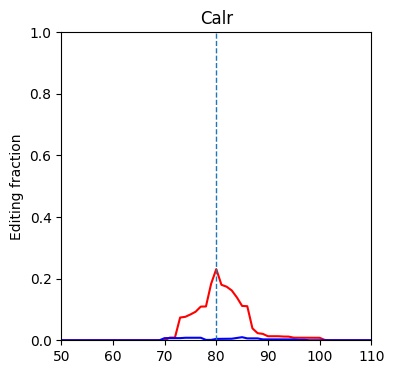

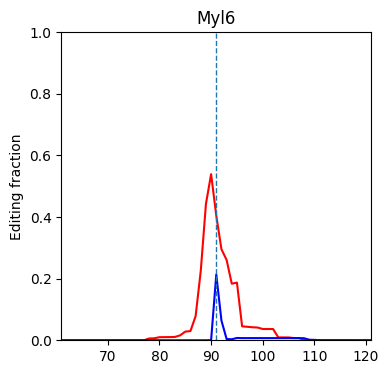

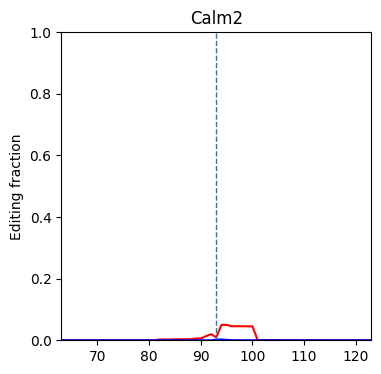

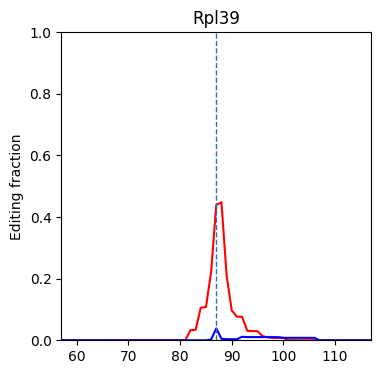

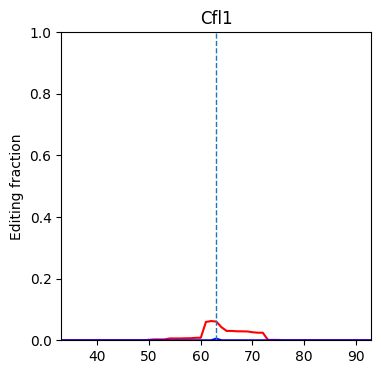

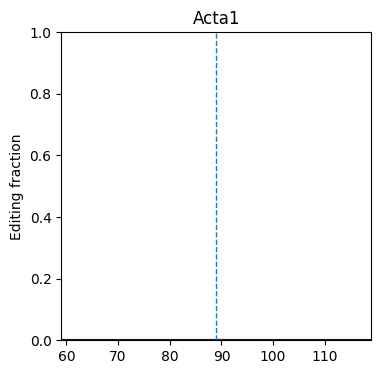

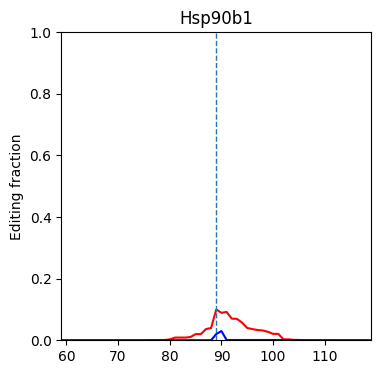

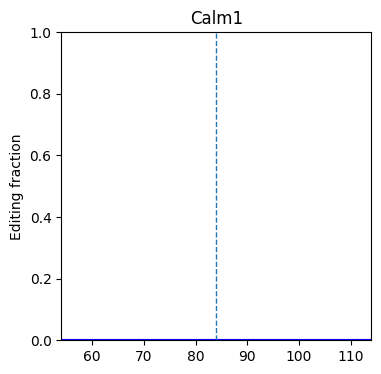

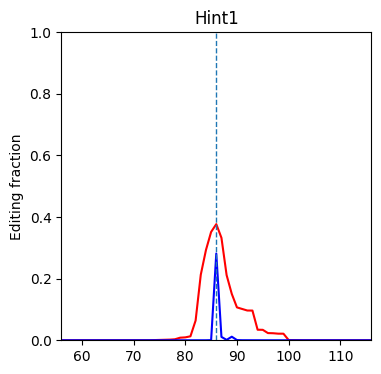

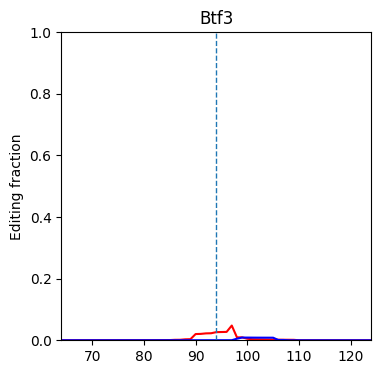

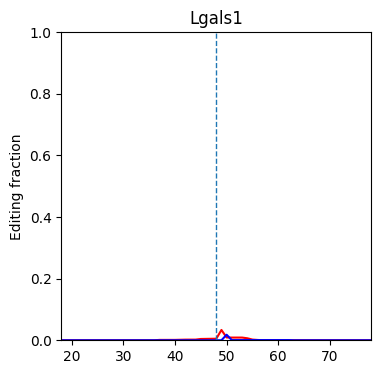

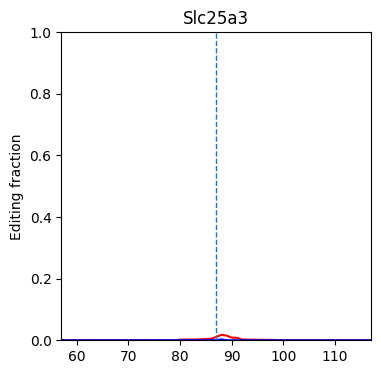

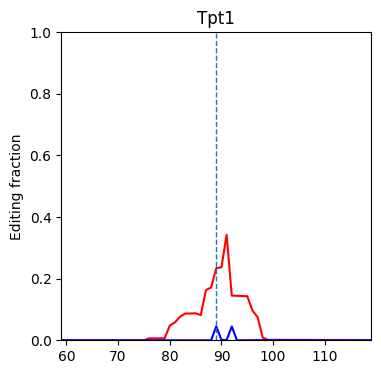

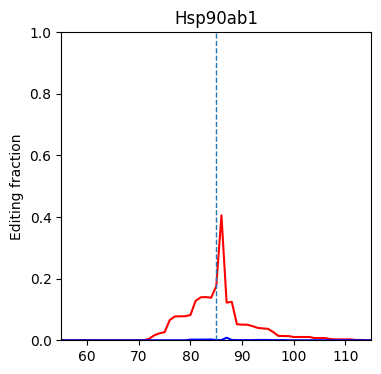

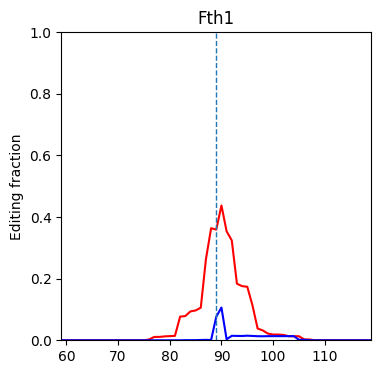

In [139]:
allele_table_sub_filter = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/SPATIAL/T2/allele_table_align_to_sc.csv',header=0,na_filter=False)
edit_info = allele_table_sub_filter
edit_info['num'] = 1
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]
cut_sites_df = pd.DataFrame(index=gene_names)
cut_sites_df['cut_sites'] = cut_sites

for intBC in gene_names:
    gene_edit_info = edit_info[edit_info['intBC']==intBC]    
    edit_matrix = edit_matrix_make(gene_edit_info)
    arr = edit_matrix
    Deletion_proportion =  (arr == -1).sum(axis=0)/ (13596*2)
    Insertion_proportion =  (arr == 1).sum(axis=0)/ (13596*2)
    
    x = np.arange(arr.shape[1])

    plt.rcParams['pdf.fonttype'] = 42
    plt.gcf().set_size_inches(4, 4)
    plt.plot(x, list(Deletion_proportion), marker='', linestyle='-', color='red')
    plt.plot(x, list(Insertion_proportion), marker='', linestyle='-', color='blue')
    plt.ylabel('Editing fraction')
    plt.title('')
    #plt.grid(True)
    plt.title(intBC)
    plt.ylim(0,1)
    plt.axvline(x=cut_sites_df.loc[intBC,'cut_sites'], linestyle='--', linewidth=1)
    plt.xlim(cut_sites_df.loc[intBC,'cut_sites']-30,cut_sites_df.loc[intBC,'cut_sites']+30)
    plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure4/spatial_edit_distribution/'+intBC+'_'+'edit_distribution'+'.pdf')
    plt.show()